# 시계열 데이터 회귀분석 - 가정 소비 전력 데이터

In [405]:
# 문제 정의 - 데이터 수집 - 데이터 처리 - 데이터 분석 - 리포팅 및 피드백

## 0. 연구 배경
- World Energy Outlook 2017 논문에 따르면 급격한 경제 성장과 인구 증가는 에너지 소비를 증가시킴.
- 한국에서는 2016년 8518만㎾ → 2017년 8650만㎾ → 2018년 9248만㎾와 같이 전력 소비가 증가 추세를 보이고 있음.
- 에너지 소비는 한번에 집중되는 경향이 있어 적절한 전력 수요 예측은 매우 중요.
- 사회, 경제적으로 중요한 전력 소비 중 27%가 가정에서 발생.
- 특히 소비 전력량을 정확히 예측하면 이에 맞는 전력 계획을 수립함으로 돌발 상황에 대처할 수 있음.

### 0.1 관련 연구

- 스트림 데이터 예측을 위한 슬라이딩 윈도우 기반 점진적 회귀분석(2007.12, 김성현, 김룡, 류근호)
- Predicting residential energy consumption using CNN-LSTM neural networks(2019.05, Tae-Young Kim, Sung-Bae Cho)
- Individual Household Electric Power Consumption Forecasting using Machine Learning Algorithms(2019.09, Sachin Bhoite)
- Slider: Incremental Sliding Window Analytics(Pramod Bhatotia, Umut A. Acar)

## 1. 문제 정의

- 문제 정의
    - 시계열 데이터를 OLS를 사용하여 회귀분석할 수 있는 방법
    - sliding_window기법에서 발생하는 다중공선선을 줄이기 위한 방법

## 2. 데이터 수집

- UC Irvine Machine Learning Repository 데이터
    - https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
- 2006년 12월부터 2010년 11월까지 47개월 동안 프랑스 파리에서 약 7km 떨어진 주거 도시 소(Sceaux) 내에 있는 한 일반 가정집의 소비 전력 시계열 데이터 207만5259건.
- 일부 컬럼에서 약 1.25%의 결측치 포함

## 3. 데이터 처리

### 3.1 CSV 파일 로드

In [3]:
import warnings
warnings.filterwarnings(action = "ignore") # 경고 무시
import pandas as pd

In [2]:
power = pd.read_csv("household_power_consumption.txt", sep=";", header=0, low_memory=False, infer_datetime_format=True, parse_dates={"datetime":[0,1]}, index_col=["datetime"])

In [9]:
# dataset 안의 ?를 nan으로 바꿔줌
from numpy import nan
from numpy import isnan
power.replace('?', nan, inplace=True)

# 데이터 타입 실수로 변환
power = power.astype("float32")

In [10]:
power.tail(100)

Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2010-11-26 19:23:00                1.070                  0.000  239.610001   
2010-11-26 19:24:00                1.120                  0.082  238.910004   
2010-11-26 19:25:00                1.126                  0.078  237.990005   
2010-11-26 19:26:00                1.264                  0.072  237.229996   
2010-11-26 19:27:00                1.260                  0.000  236.139999   
...                                  ...                    ...         ...   
2010-11-26 20:58:00                0.946                  0.000  240.429993   
2010-11-26 20:59:00                0.944                  0.000  240.000000   
2010-11-26 21:00:00                0.938                  0.000  239.820007   
2010-11-26 21:01:00                0.934                  0.000  239.699997   
2010-11-26 21:02:00                0.932                  0.000  239.550003   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2010-11-26 19:23:00               4.4             0.0             0.0   
2010-11-26 19:24:00               4.6             0.0             0.0   
2010-11-26 19:25:00               4.8             0.0             0.0   
2010-11-26 19:26:00               5.4             0.0             0.0   
2010-11-26 19:27:00               5.4             0.0             0.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
datetime                             
2010-11-26 19:23:00             0.0  
2010-11-26 19:24:00             0.0  
2010-11-26 19:25:00             0.0  
2010-11-26 19:26:00             0.0  
2010-11-26 19:27:00             0.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[100 rows x 7 columns]

In [408]:
power.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


- 데이터 설명
    - 1.date: Date in format dd/mm/yyyy
    - 2.time: time in format hh:mm:ss
    - 3.global_active_power(유효전력): household global minute-averaged active power (in kilowatt)
    - 4.global_reactive_power(무효전력): household global minute-averaged reactive power (in kilowatt)
    - 5.voltage(전압): minute-averaged voltage (in volt)
    - 6.global_intensity(전류): household global minute-averaged current intensity (in ampere)
    - 7.sub_metering_1(식기세척기, 오븐, 전자레인지 등 주방 가전 관련): energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
    - 8.sub_metering_2(세탁기, 건조기, 냉장고 등 세탁실 관련): energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
    - 9.sub_metering_3(냉난방 가전 관련): energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### 3.2 결측 데이터 확인

In [11]:
import missingno as msno

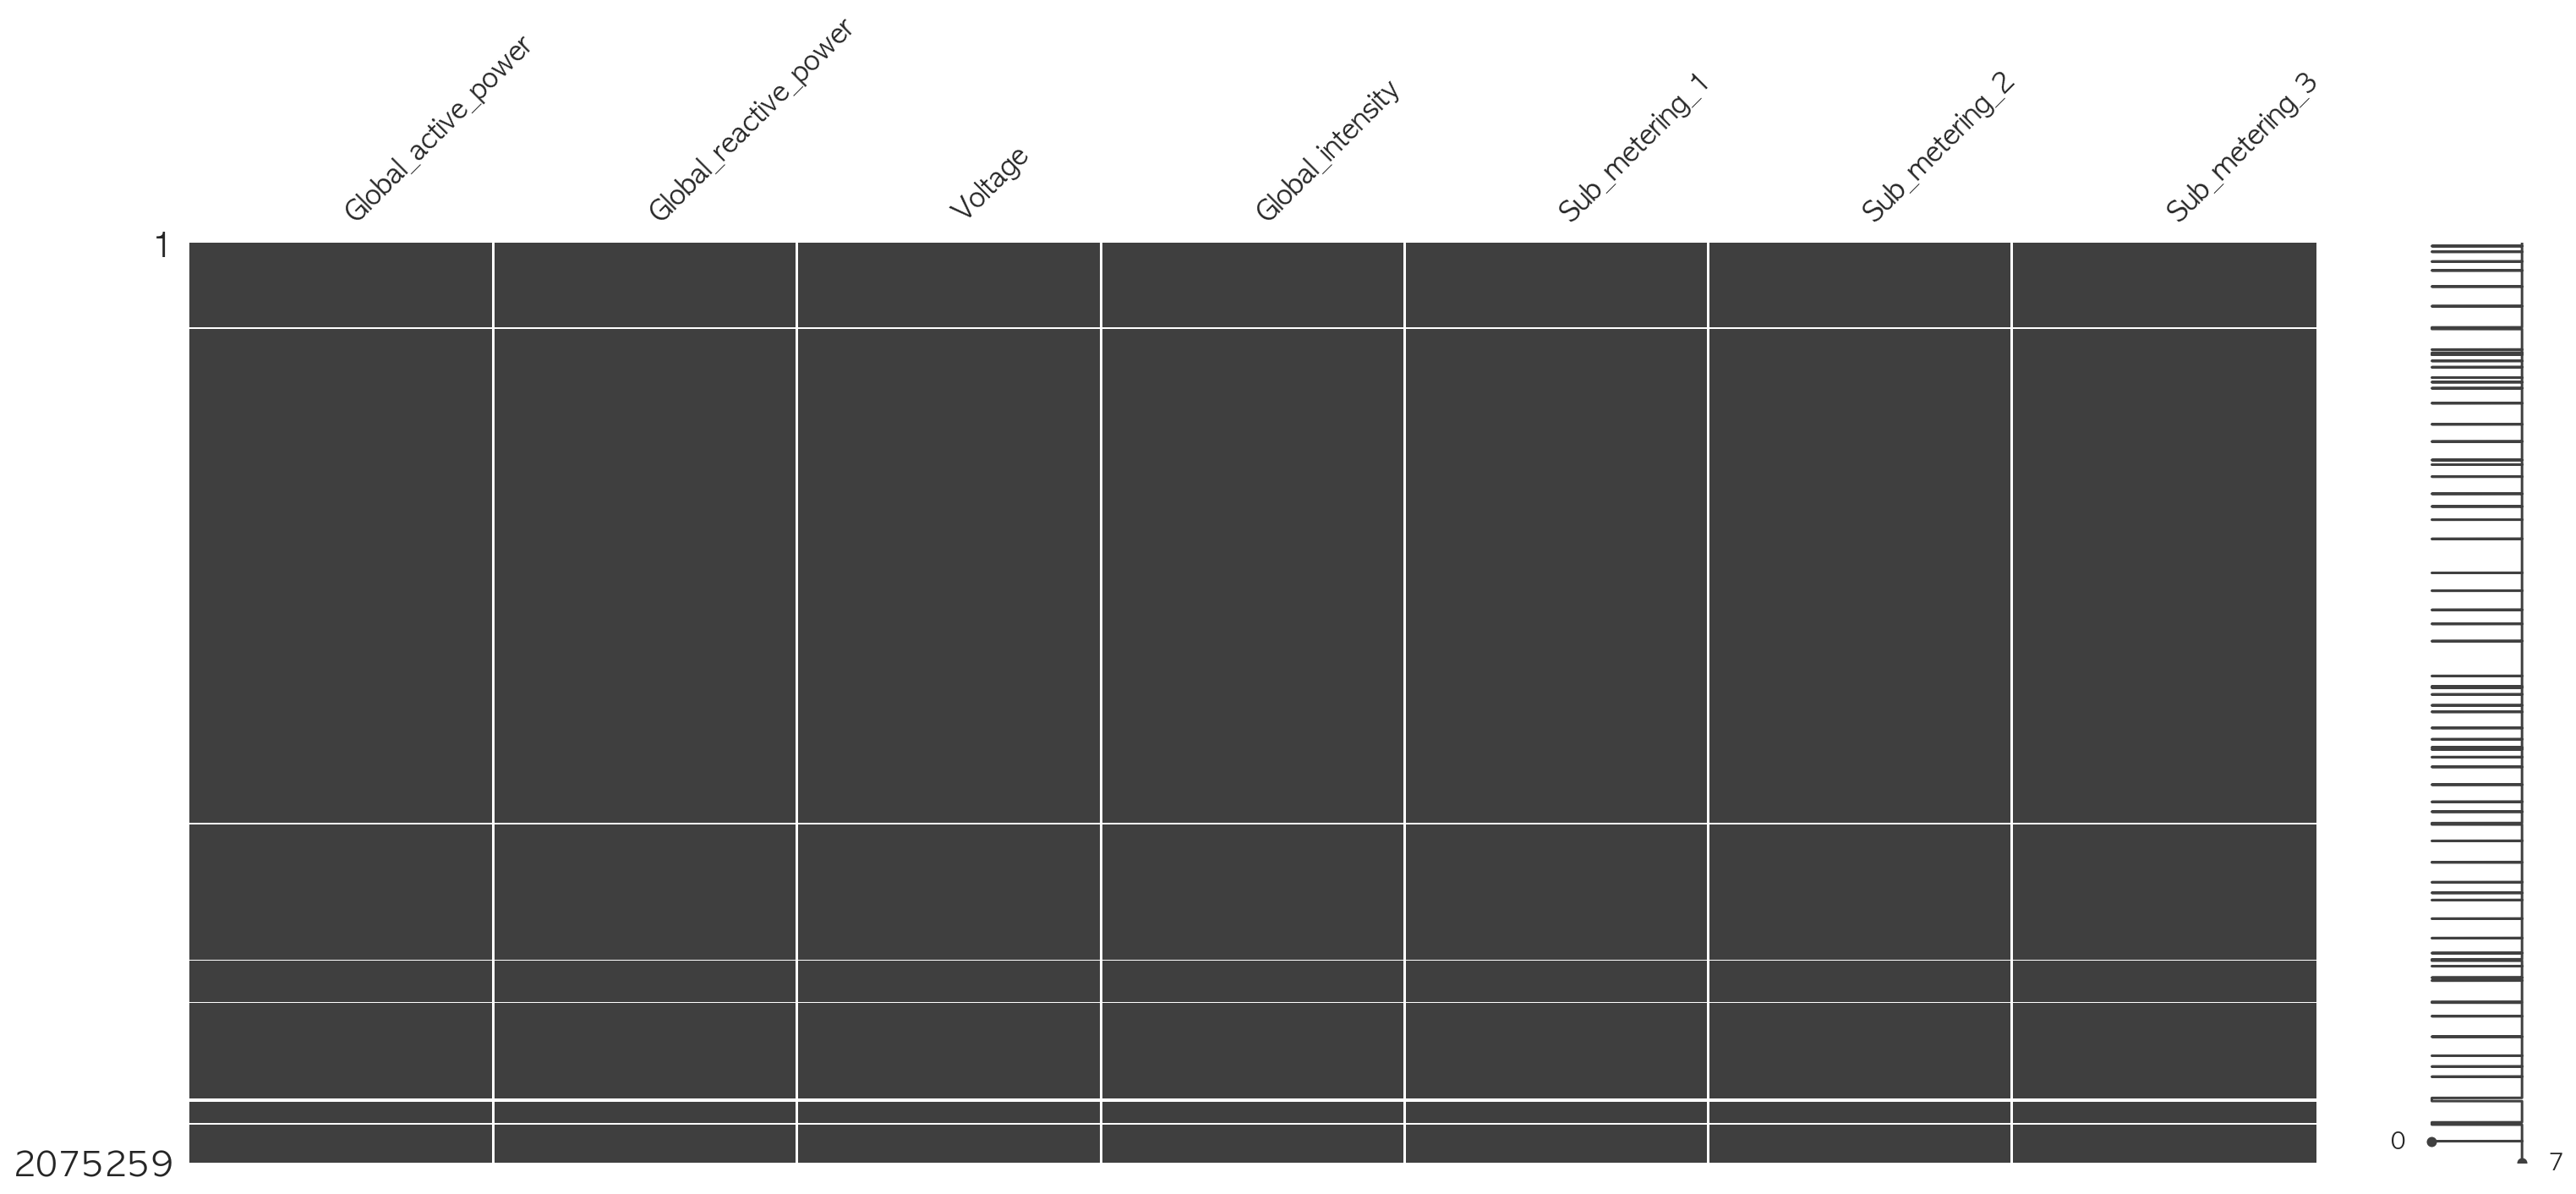

In [12]:
msno.matrix(power)
#msno.bar(power)

### 3.3 결측데이터 대체(imputation)

In [195]:
# 거의 일정한 값을 가진 Voltage 독립변수를 제외한 다른 변수들은 당시의 시기(계절)에 따라 변화하는 값이므로 누락값을 전날 같은 시간대 값으로 대체해 처리

In [13]:
# 하루 전 같은 시간대 데이터로 누락값 대체
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
                
fill_missing(power.values)

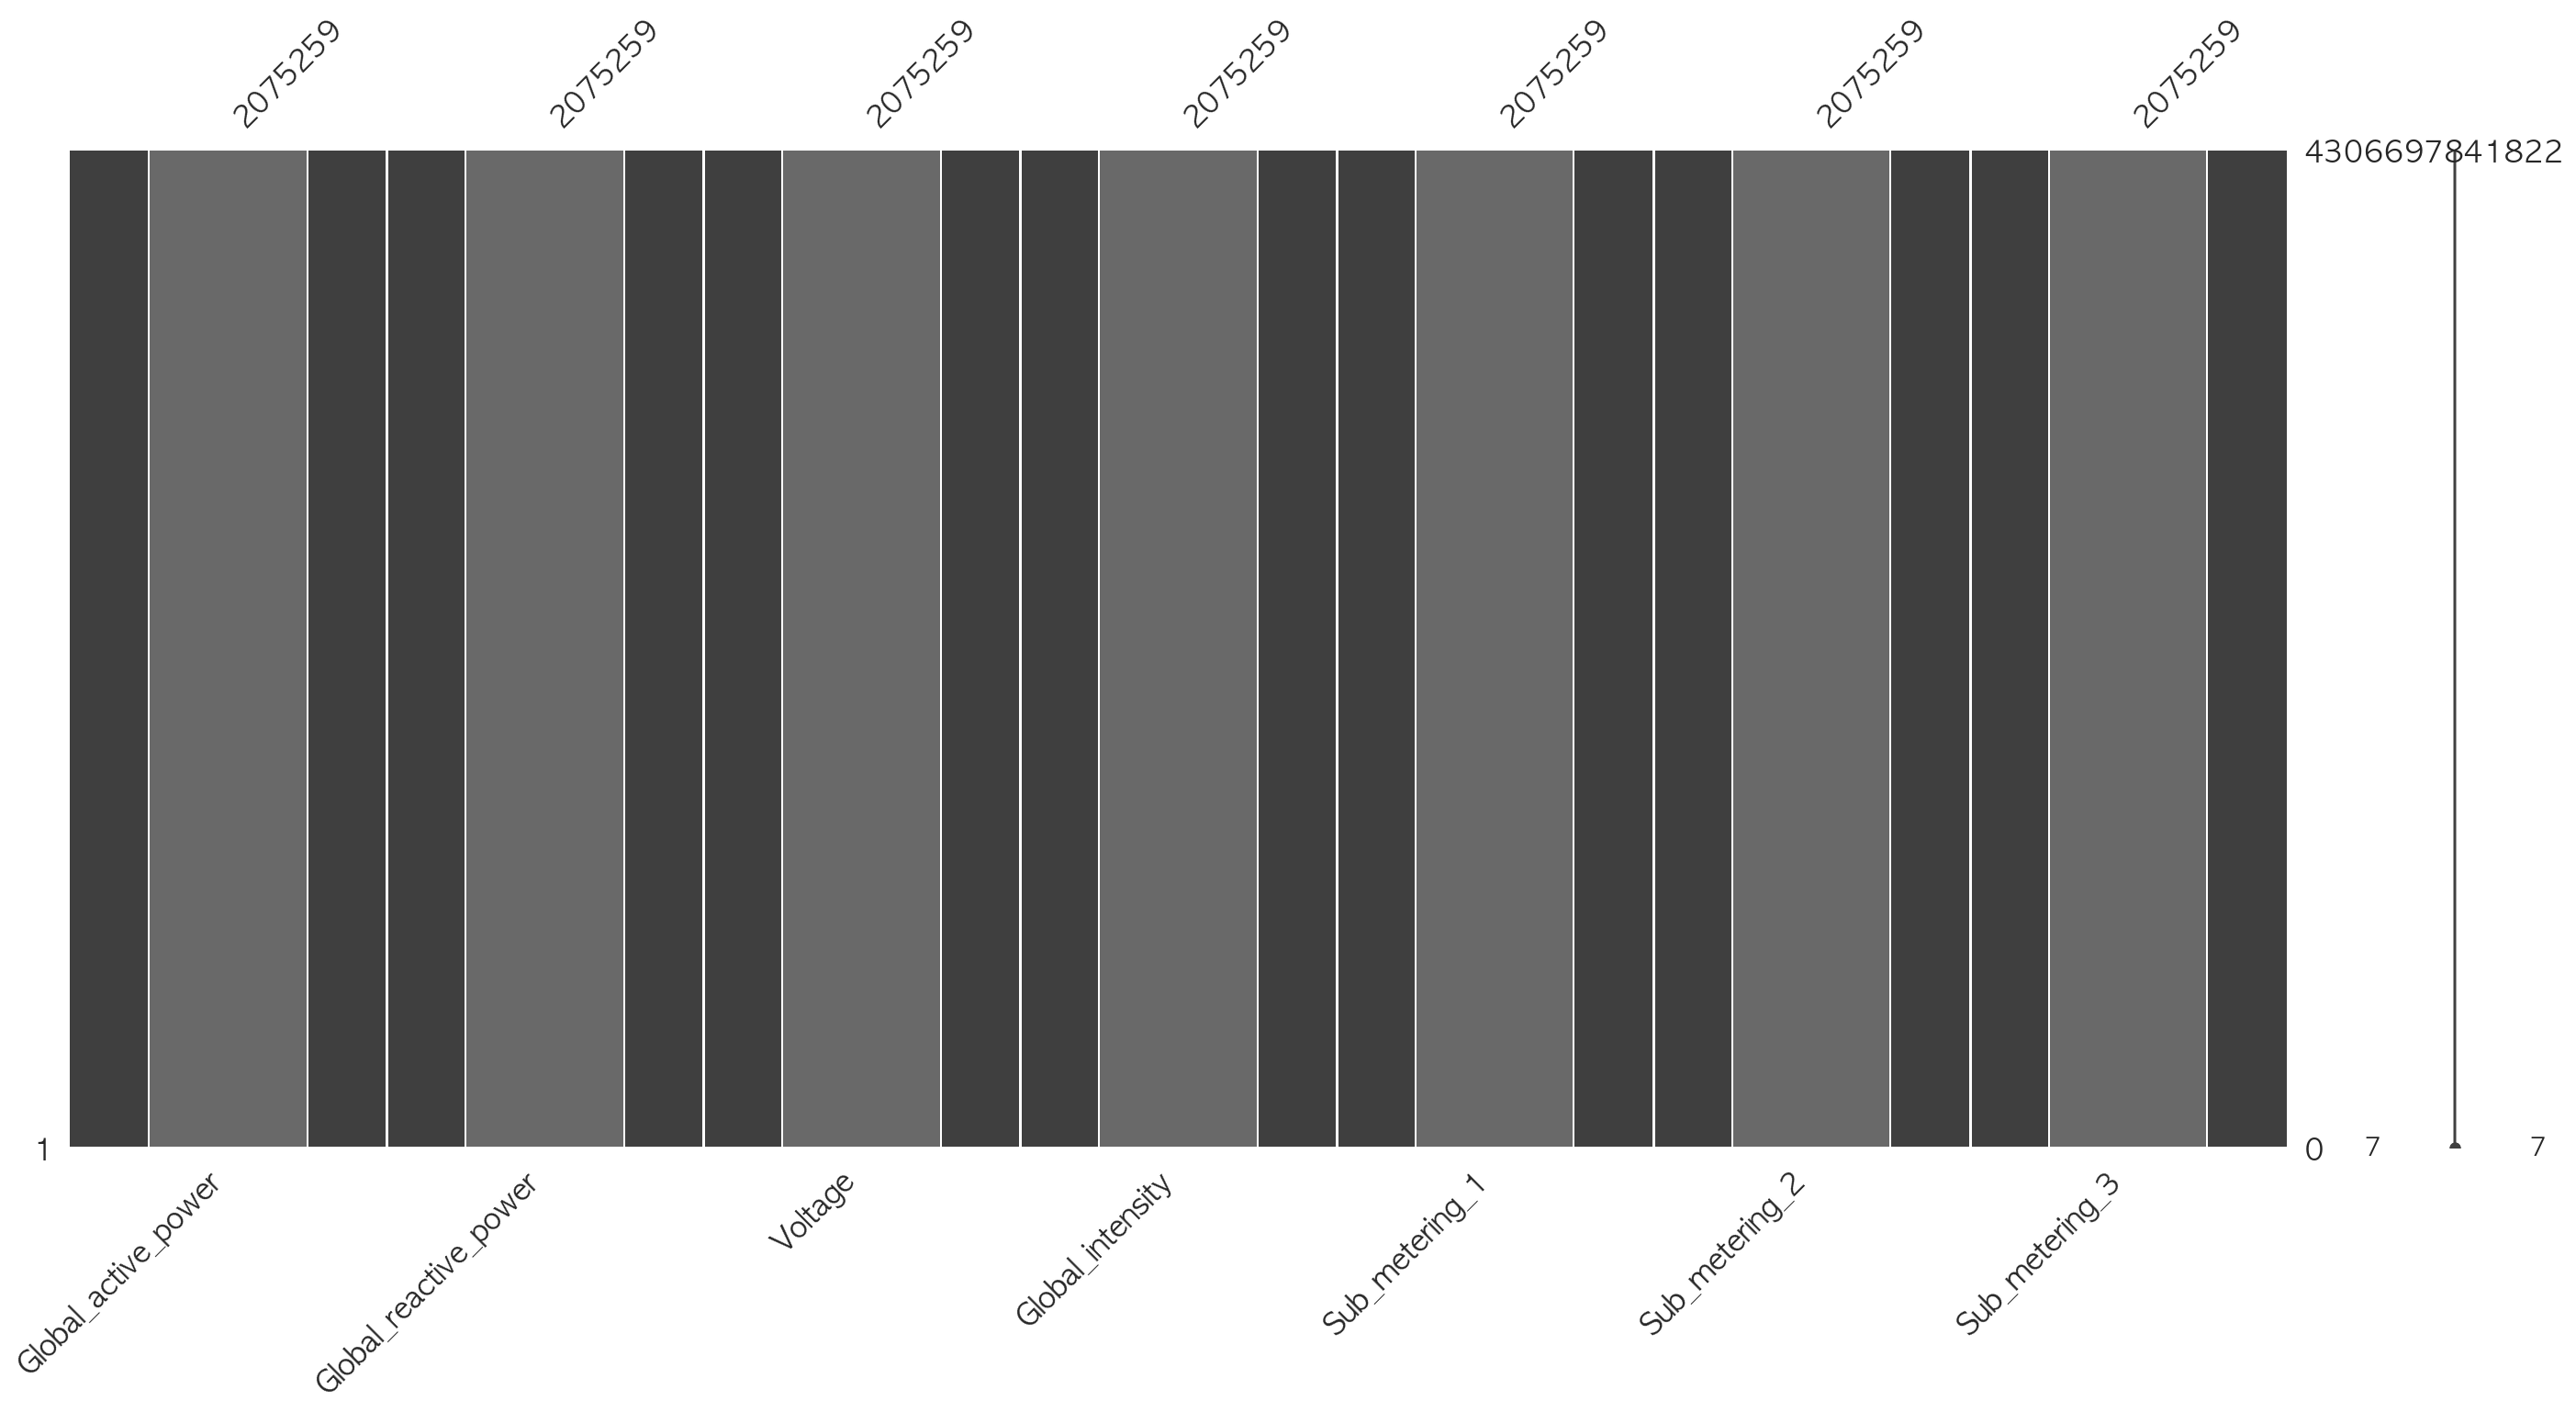

In [14]:
msno.matrix(power)
msno.bar(power)

### 3.4 sub_metering_4 추가

In [41]:
# sub_metering_4 컬럼 추가
# (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
values = power.values
power["sub_metering_4"] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [24]:
# 지금까지 한 내용들을 csv 파일로 1차 저장
power.to_csv("household_power_consumption.csv")

### 3.5 resolution 조정

In [30]:
# 시간 단위로 레졸루션 조정
time_resolution = "H"
power_resampled = power.resample(time_resolution).mean()

# summarize
print(power_resampled.shape)
print(power_resampled.head())
power_resampled.to_csv("household_power_consumption_%s.csv" %(time_resolution))

(34589, 8)
                     Global_active_power  Global_reactive_power     Voltage  \
datetime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643890   
2006-12-16 18:00:00             3.632200               0.080033  234.580170   
2006-12-16 19:00:00             3.400233               0.085233  233.232498   
2006-12-16 20:00:00             3.268567               0.075100  234.071503   
2006-12-16 21:00:00             3.056467               0.076667  237.158661   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000 

In [4]:
#df_power = pd.read_csv("household_power_consumption_H.csv", header=0, low_memory=False, index_col=["datetime"])
#df_power = df_power.astype("float32")
#df_power.iloc[:, 0:7].reset_index(drop=True)

df_power = pd.read_csv("household_power_consumption_H.csv", header=None, skiprows=1).values[:, 1:].astype("float")
df_power

array([[4.2228890e+00, 2.2900000e-01, 2.3464389e+02, ..., 5.2777780e-01,
        1.6861110e+01, 5.2992590e+01],
       [3.6322000e+00, 8.0033330e-02, 2.3458017e+02, ..., 6.7166667e+00,
        1.6866667e+01, 3.6953335e+01],
       [3.4002333e+00, 8.5233330e-02, 2.3323250e+02, ..., 1.4333333e+00,
        1.6683332e+01, 3.8553890e+01],
       ...,
       [1.6593333e+00, 6.0033333e-02, 2.3674100e+02, ..., 6.6666670e-02,
        0.0000000e+00, 2.7588888e+01],
       [1.1637000e+00, 6.1166666e-02, 2.3939600e+02, ..., 1.0666667e+00,
        0.0000000e+00, 1.8328333e+01],
       [9.3466670e-01, 0.0000000e+00, 2.3969000e+02, ..., 0.0000000e+00,
        0.0000000e+00, 1.5577778e+01]])

### 3.6 스케일링

In [188]:
# 데이터 MinMax 스케일링
df_norm = np.copy(df_power)
for c in range(8):
    df_norm[:, c] -= df_power[:, c].min()
    df_norm[:, c] /= (df_power[:, c].max()-df_power[:, c].min())
print(df_norm.shape)

# 스케일링은 자료 집합에 적용되는 전처리 과정으로 모든 자료에 선형 변환을 적용하여 전체 자료의 분포를 평균 0, 분산 1이 되도록 만드는 과정.
    # 스케일링은 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지
    # 독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상.

# StandardScaler(X): 평균이 0과 표준편차가 1이 되도록 변환.
# RobustScaler(X): 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.
# MinMaxScaler(X): 최대값이 각각 1, 최소값이 0이 되도록 변환
# MaxAbsScaler(X): 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환

# https://study-grow.tistory.com/9
# 스케일링은 : 0~1, -1~1 사이로 크기 조정
# 표준화 : 평균 0, 표준편차는 1로
# 정규화 : 특징 벡터의 길이가 1이 되게
# 최적화 : 함수의 값을 가장 크게 혹은 작게 만드는 입력변수의 값을 찾는 문제

(34589, 8)


## 4. 탐색적 데이터 분석(EDA)

- 가설 수립:
    - 전류는 유효전력과 비슷한 움직임을 보일 것이다.
    - 전압은 일정할 것이다.
    - 직전의 전력량은 직후의 전력량에 영향을 미칠 것이다.
    - 전력량은 겨울에서 봄, 여름에서 가을로 갈수록 낮아지고, 봄에서 여름, 가을에서 겨울로 갈수록 높아질 것이다.
        - 여름의 전력량이 가장 클 것이다.

#### 4.1 추세 분석

In [47]:
df = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=["datetime"], index_col=["datetime"])
df.head()

Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  sub_metering_4  
datetime                                             
2006-12-16 17:24:00            17.0       52.266670  
2006-12-16 17:25:00            16.0       72.333336  
2006-12-16 17:26:00            17.0       70.566666  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000

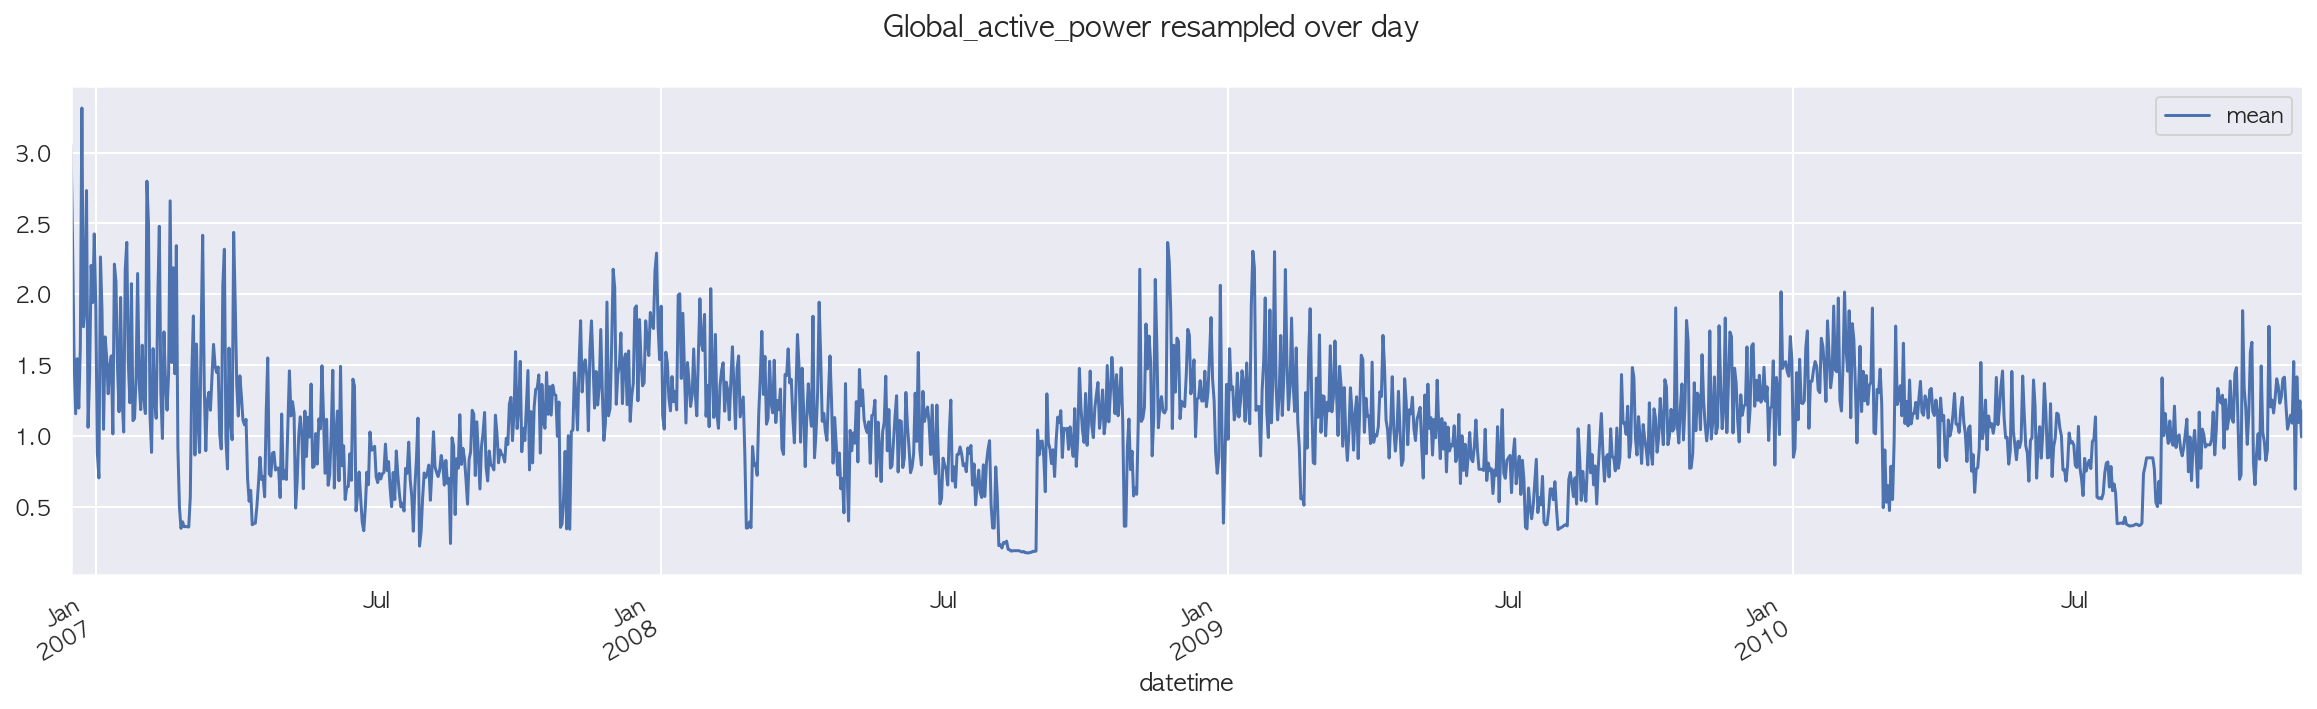

In [97]:
# 일자별 유효전력 평균
a = df.Global_active_power.resample('D').agg(['mean'])

a.plot(subplots = True, title='Global_active_power resampled over day', figsize=(20,5))
plt.show()

In [342]:
# 1월에서 7월로 갈수록 낮아지고 7월에서 1월로 갈수록 높아지는 경향을 보인다

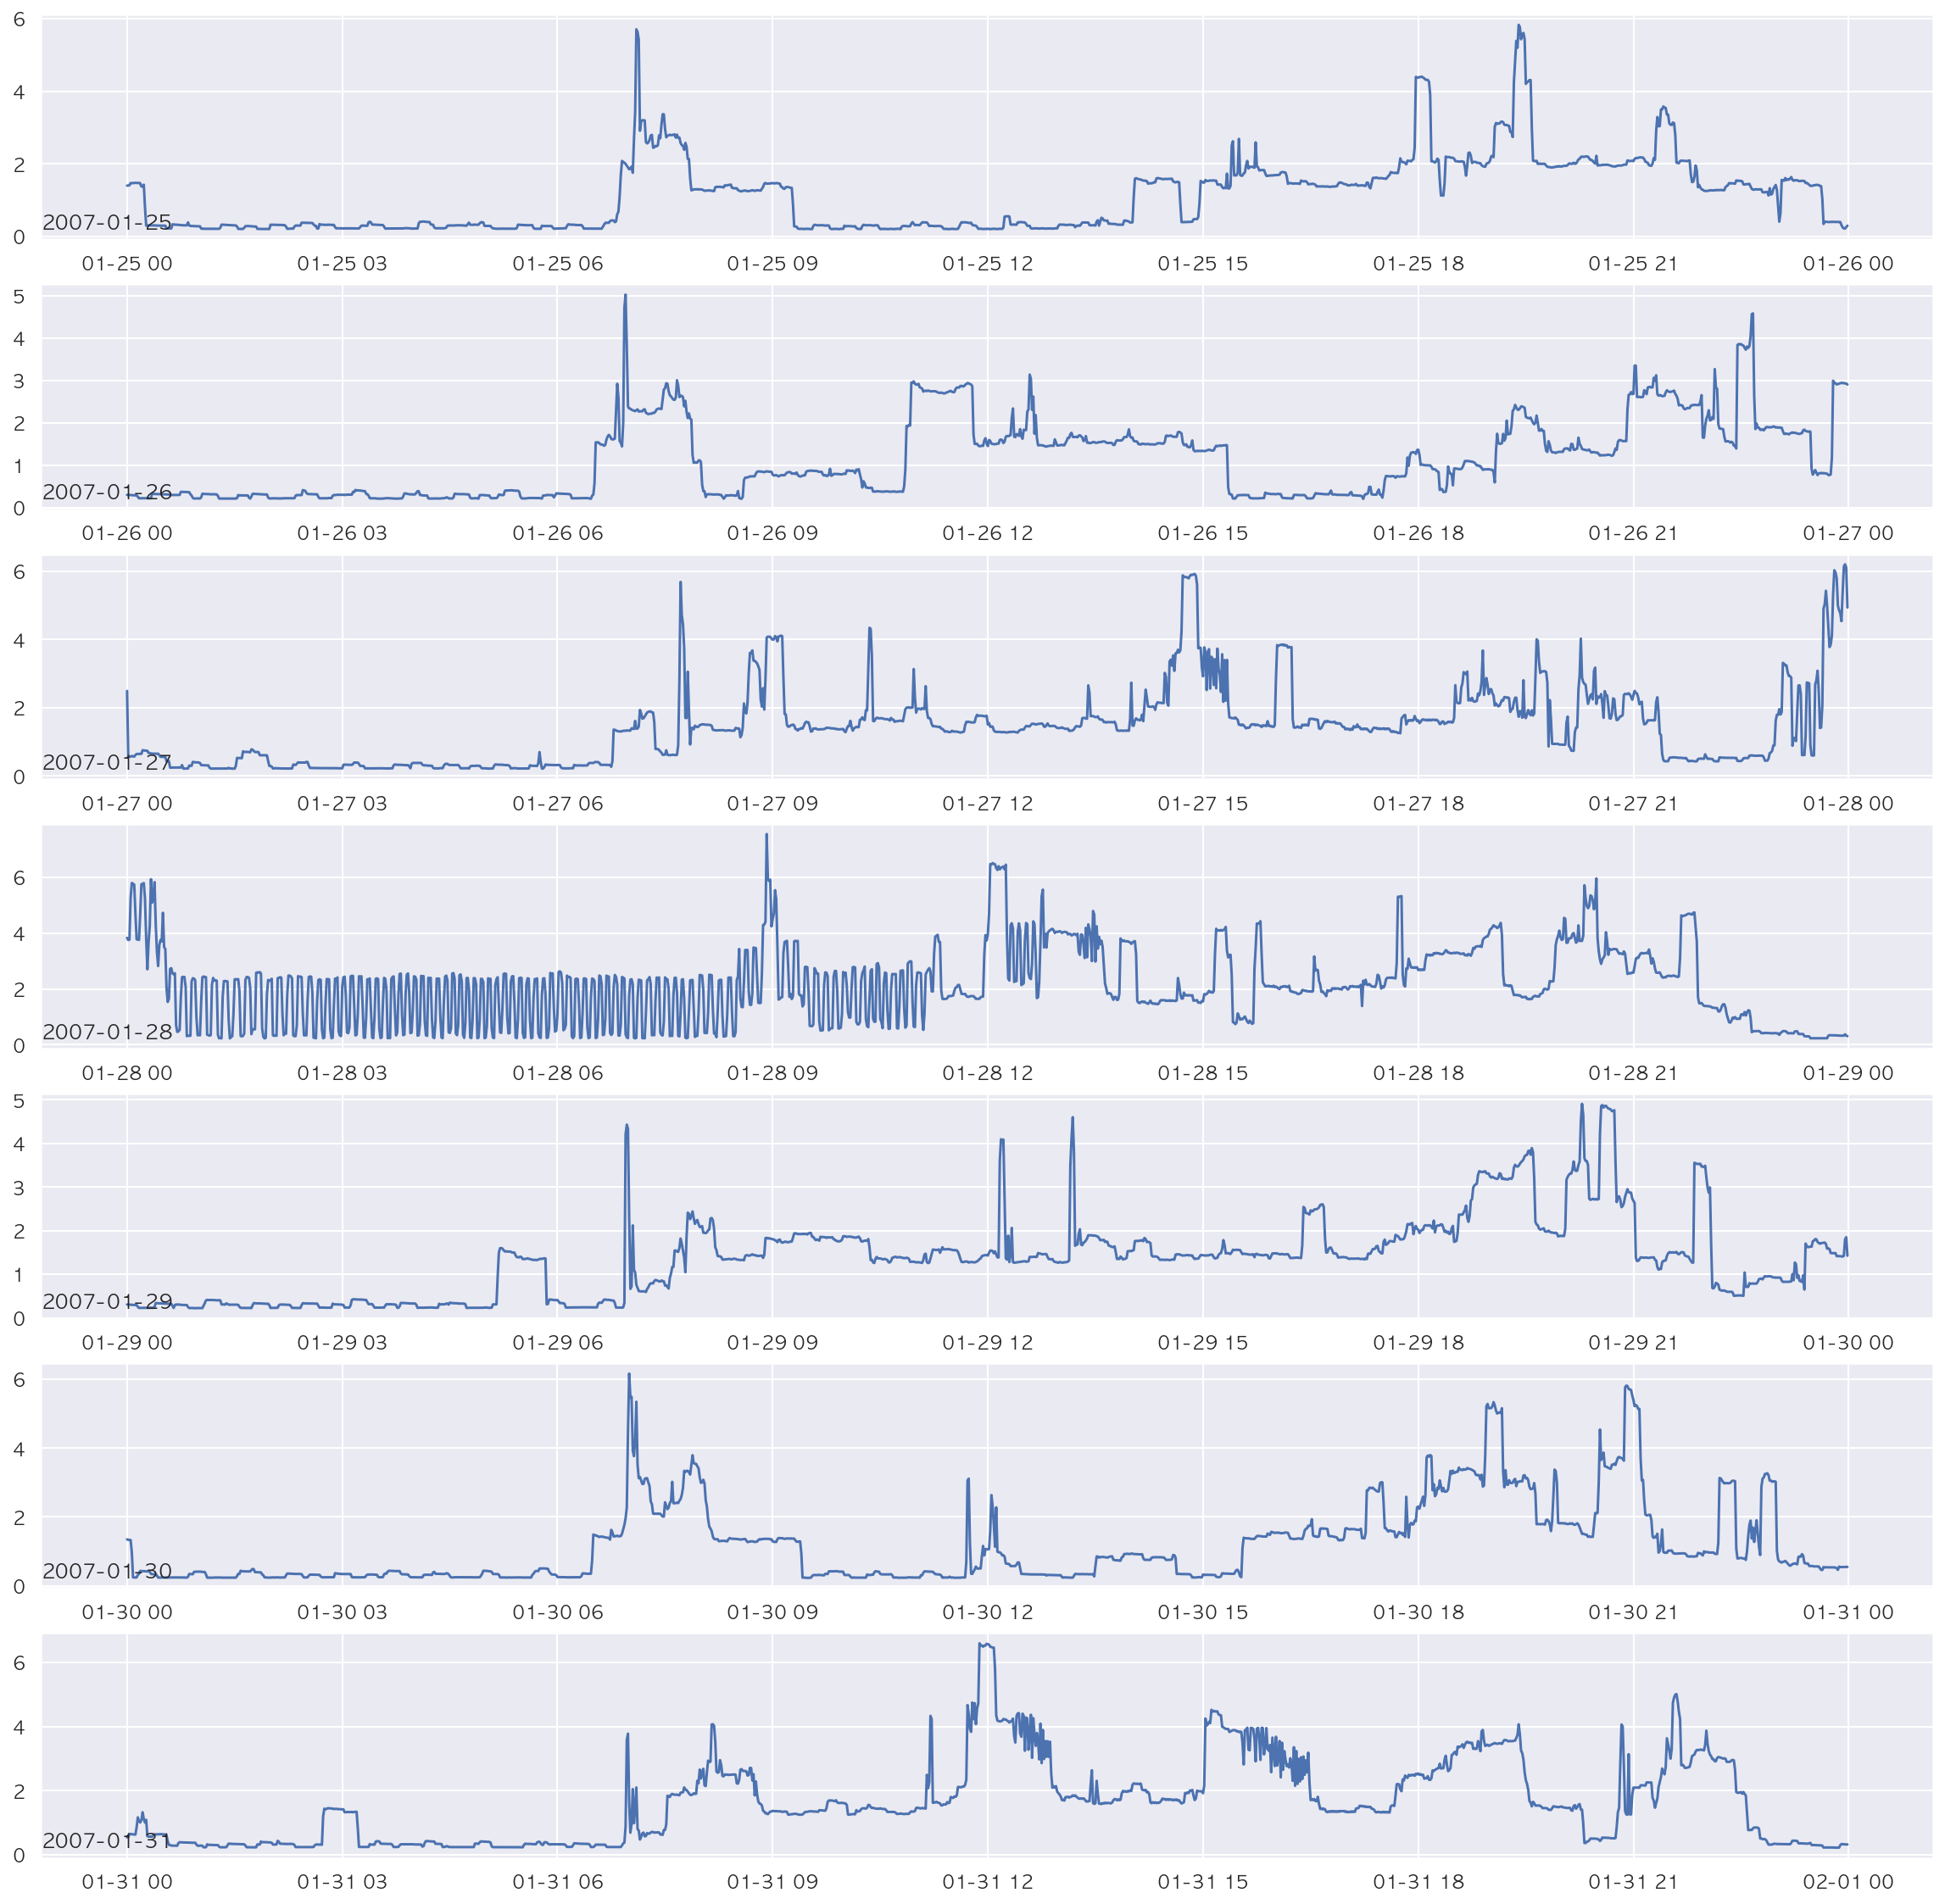

In [93]:
# 하루 유효전력 변화
days = [x for x in range(25, 32)]
plt.figure(figsize=(20,20))
for i in range(len(days)):
    ax = plt.subplot(len(days), 1, i+1)
    day = '2007-01-' + str(days[i])
    result = df[day]
    plt.plot(result['Global_active_power'])
    plt.title(day, y=0, loc='left')
plt.show()

In [ ]:
# 유효 전력이 출근 시간 전인 오전 6시~9시 사이에 유효 전력이 상승, 퇴근 시간 이후인 오후 6시~자정까지 다시 또 상승하는 모습을 보임

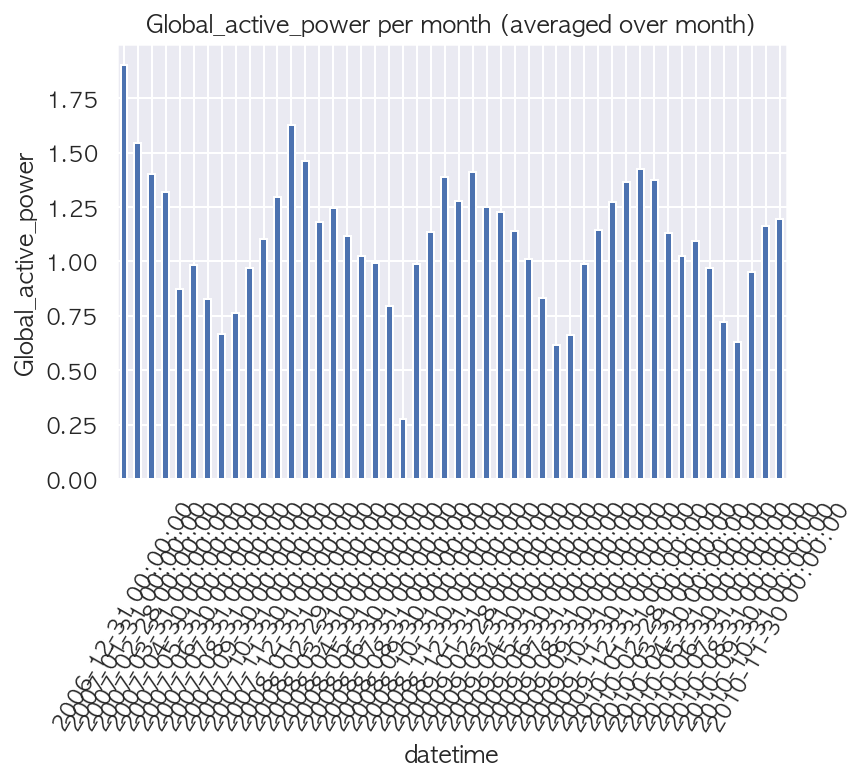

In [103]:
# 월별 유효전력 평균
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

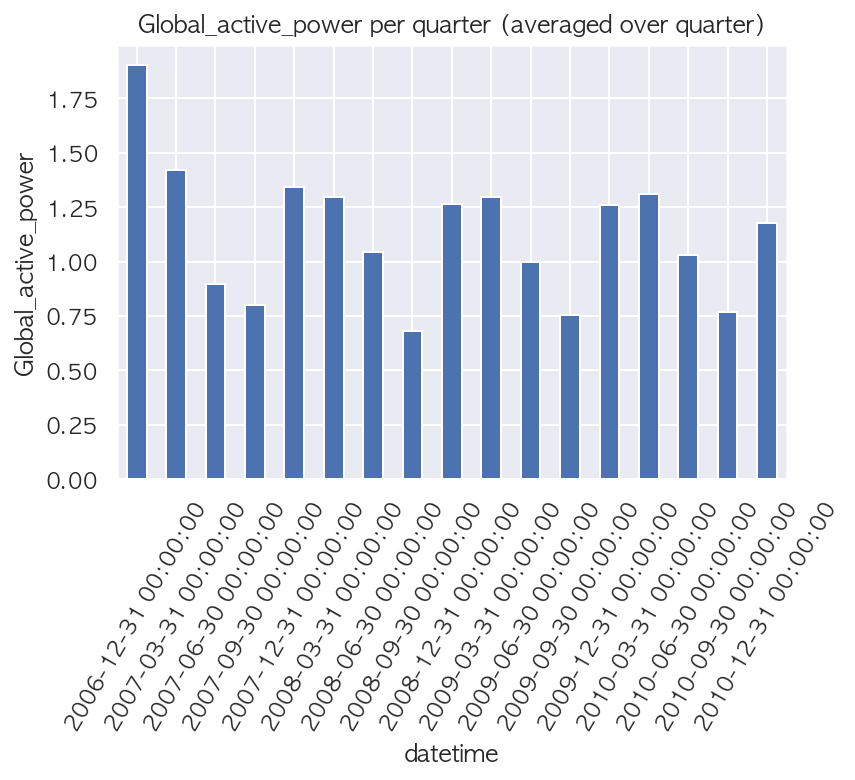

In [57]:
## 분기별 광역전력 평균
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

In [58]:
df1 = df["2007"]
df2 = df["2008"]
df3 = df["2009"]
df4 = df["2010"]
df5 = pd.concat([df1, df2, df3, df4])

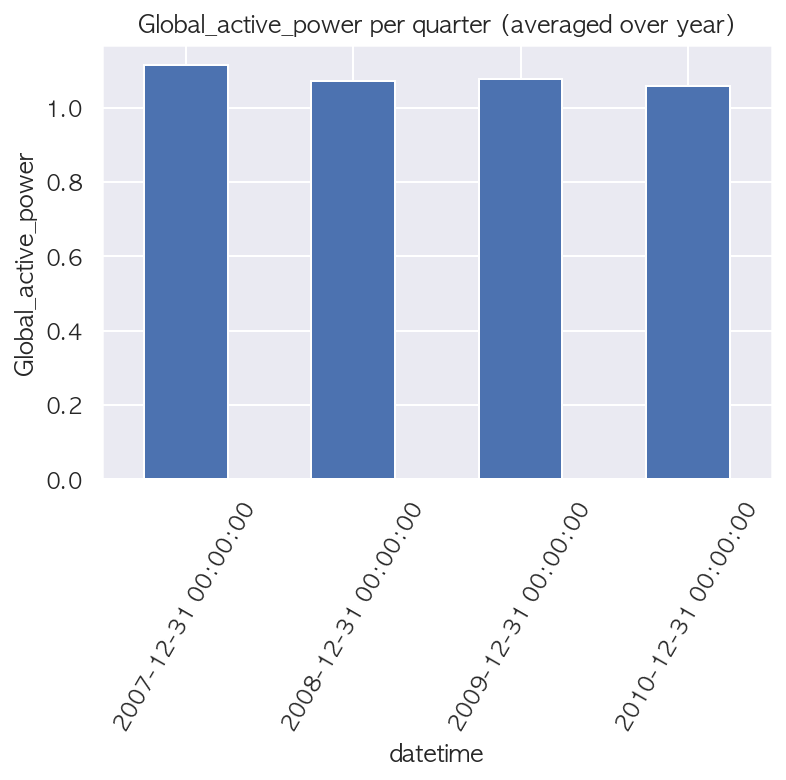

In [59]:
## 연도별 유효전력 평균
df5['Global_active_power'].resample('A').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over year)')
plt.show()

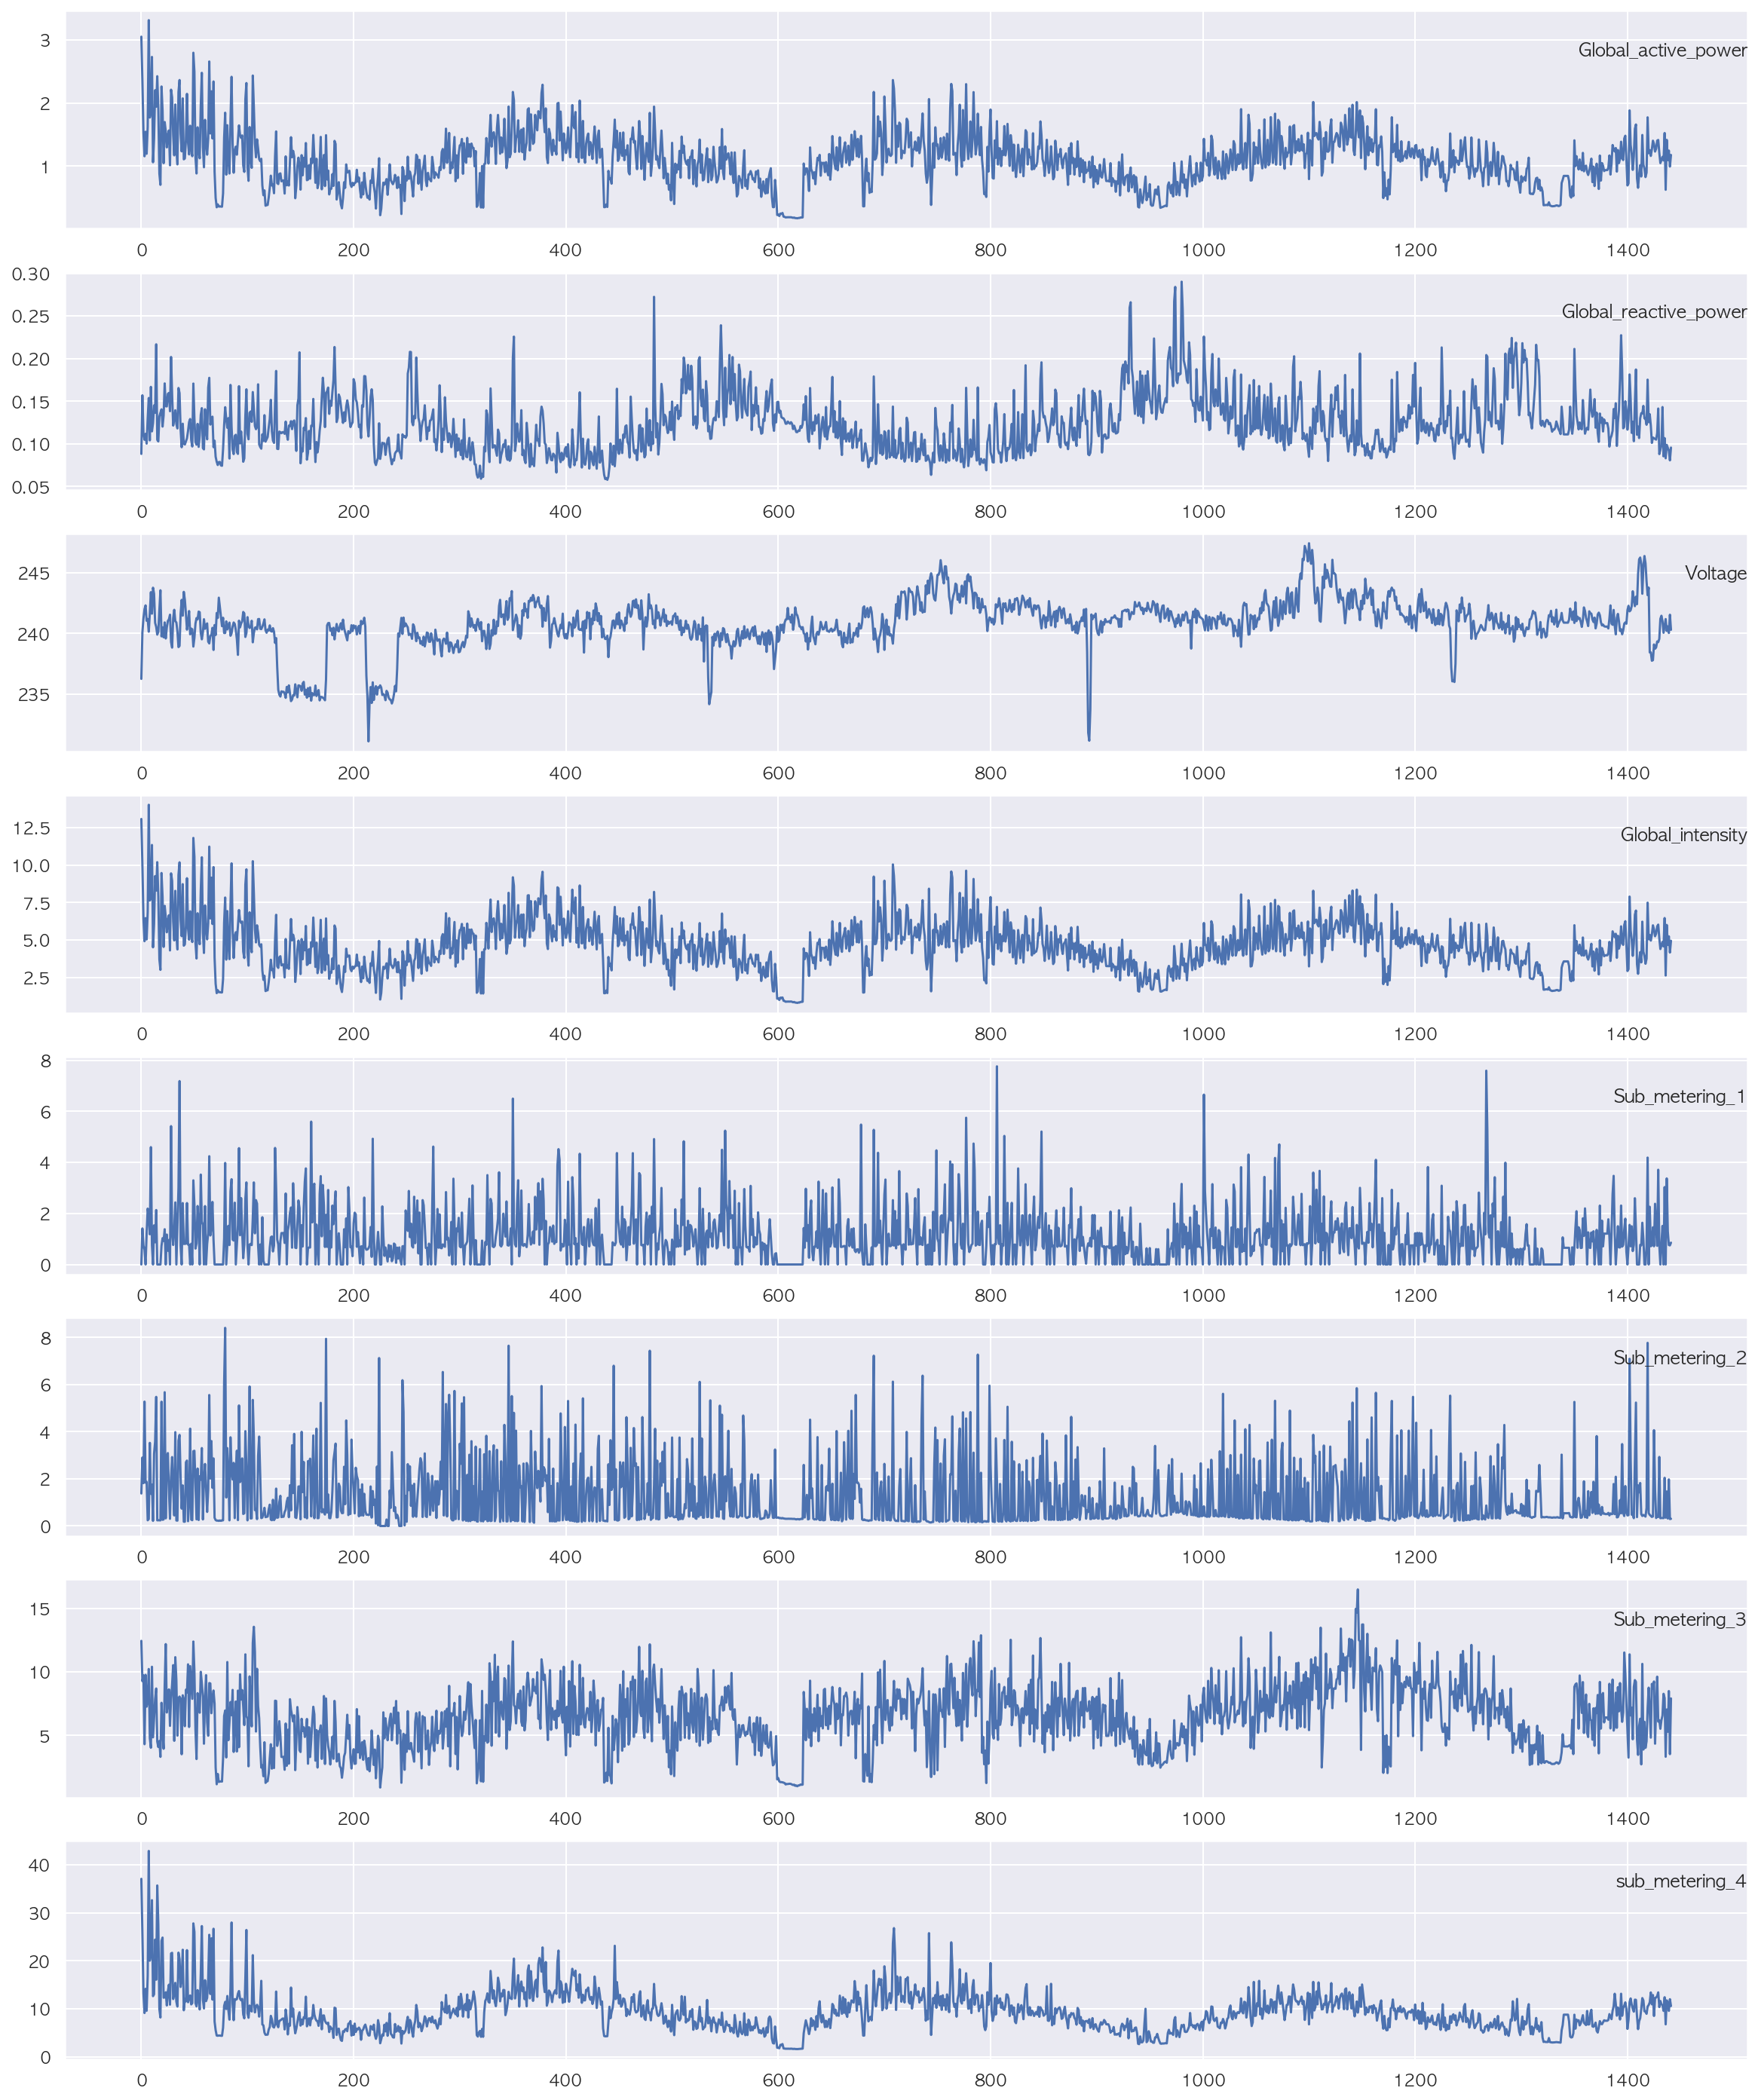

In [106]:
# 하루 단위로 리샘플 했을 때 독립변수들의 평균 변화(mean of different features resampled over day)
# specify columns to plot
cols = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(20, 25))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, col])
    plt.title(df.columns[col], y=0.75, loc='right')
    i += 1
plt.show()

In [ ]:
# 전압은 240v 정도로 일정, 전류는 전력과 같이 움직이는 것을 확인할 수 있음

### 4.2 정규성 검증

In [65]:
# 회귀분석 가능한 데이터인가

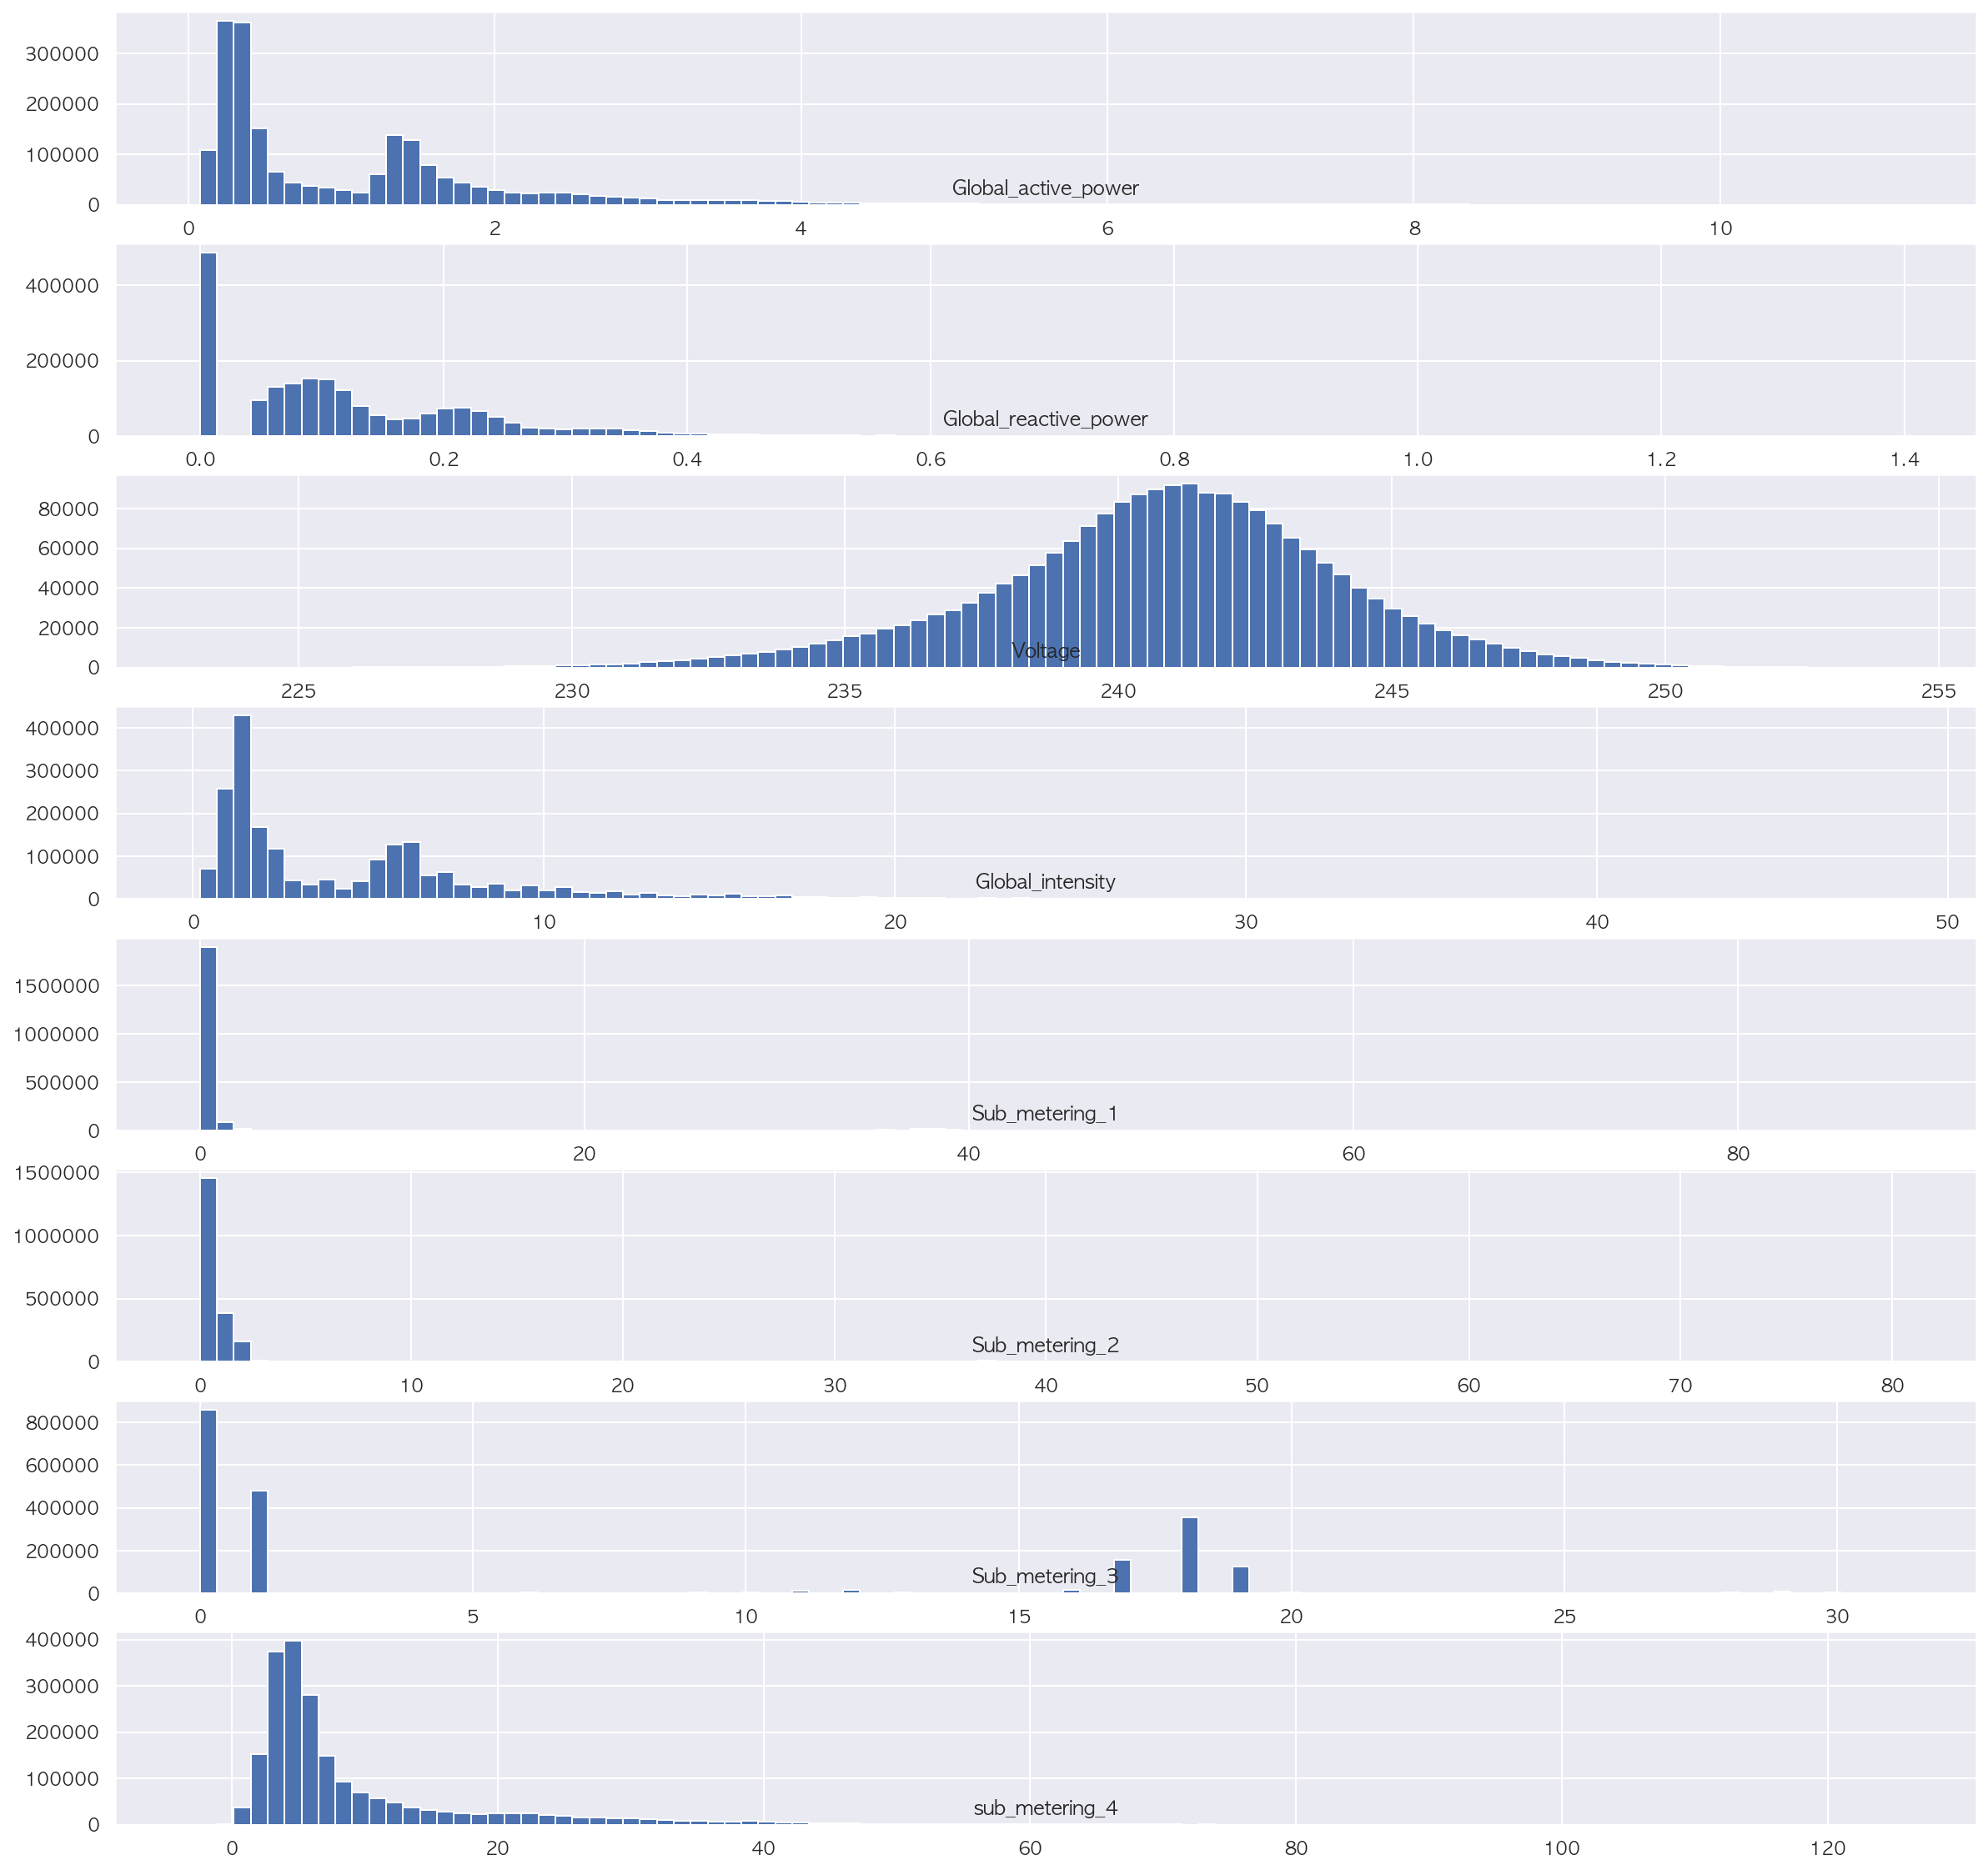

In [107]:
# 독립변수 정규성 검증
plt.figure(figsize=(20,20))
for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    name = df.columns[i]
    df[name].hist(bins=100)
    plt.title(name, y=0)
plt.show()

In [78]:
# 다봉분포가 보이지만 정규분포를 합친 모양이므로 괜찮음

In [66]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

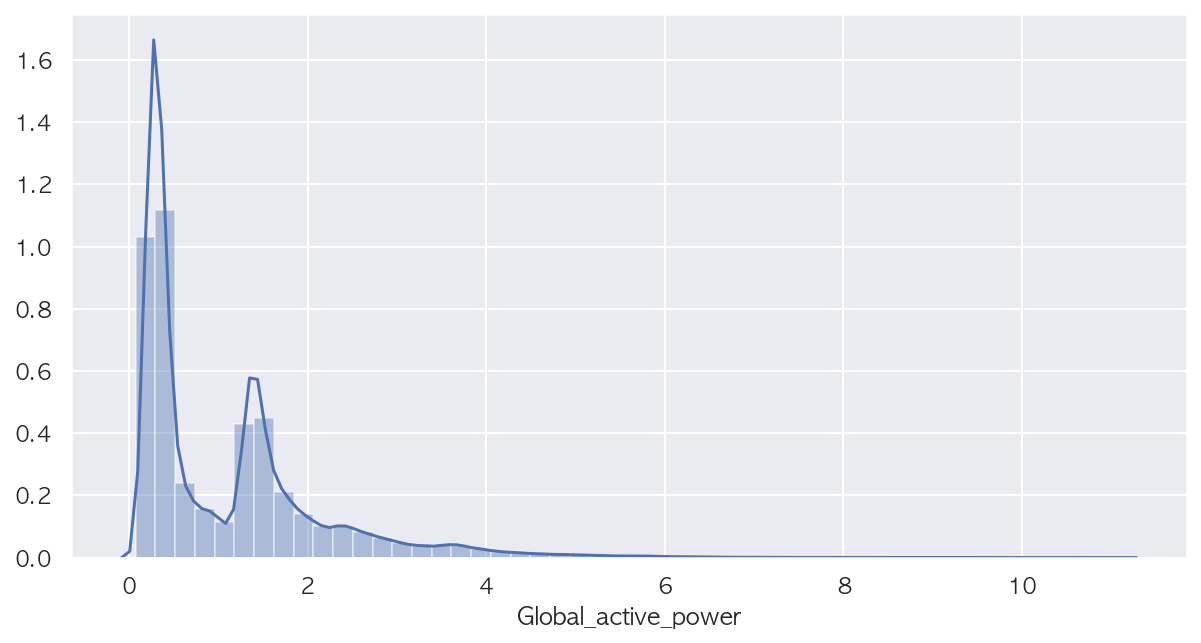

In [110]:
plt.figure(figsize=(10,5))
sns.distplot(df["Global_active_power"])

### 4.3 상관관계 분석

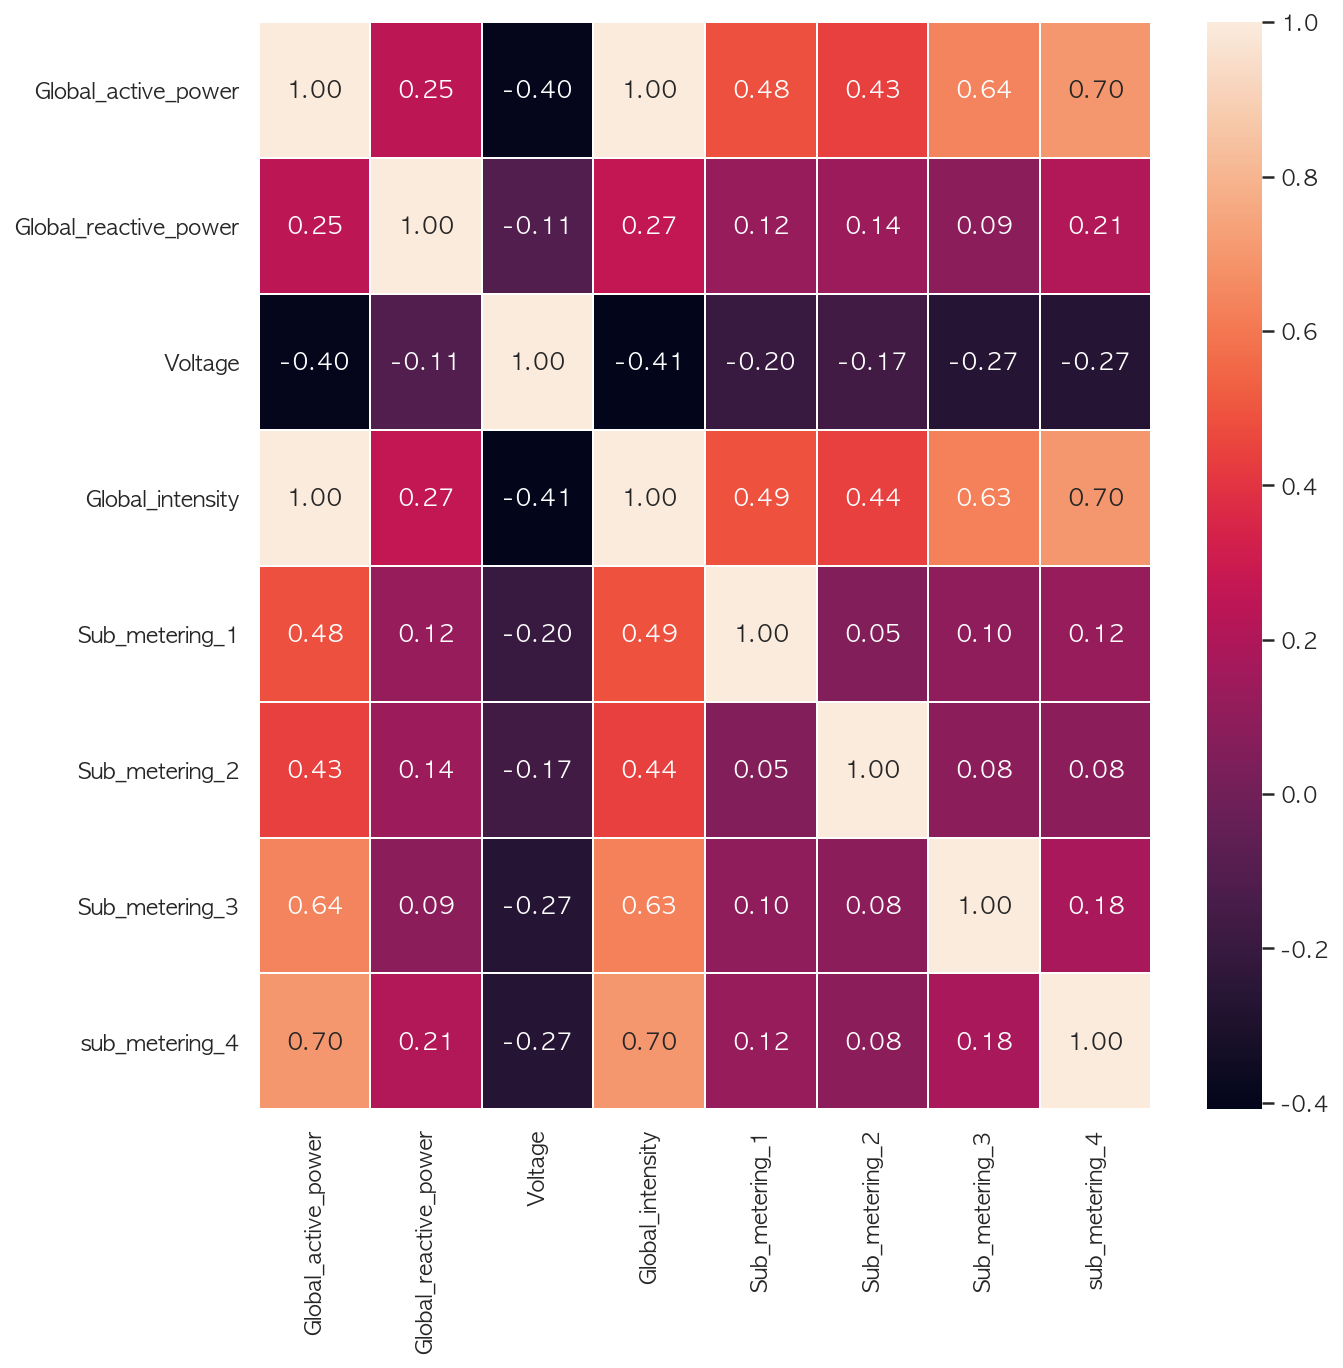

In [69]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(), annot = True, linewidths = .5, fmt = ".2f", ax=ax)

In [344]:
# 유효전력과 전류, 유효전력과 sub_metering_4, 전류와 sub_metering_4가 서로 상관성이 큰 것으로 나타났다.
# 유효전력, 전류, sub_metering_4가 상관성이 크다

## 5. 회귀분석

### 5.1 슬라이딩 윈도우

In [71]:
# 논문 : 스트림 데이터 예측을 위한 슬라이딩 윈도우 기반 점진적 회귀분석(김성현, 김룡, 류근호)
    # 시계열 데이터 예측은 과거 데이터를 통해 미래를 예측해 유용한 정보를 얻는 것
    # 기존의 시계열 예측 기법으로는 단순 이동 평균법, 지수 평활법, ARIMA 모형 등이 있다.
    # 단순 이동 평균법(MA(Moving Average) 모형)은 가장 최근의 m- 기간의 자료들 평균을 다음 시점의 예측 값으로 추정한다.
        # 이 방법은 시간의 경과에 따라 평균의 변화가 크지 않을 경우에 적용 가능하다
# 즉 MA 모형은 불규칙 변동을 평활시켜서 시계열의 미래 값 예측(https://blog.naver.com/2sat/221181833497)
# t-1, t-2, ..., t-p 시점의 평균 데이터가 t 시점의 데이터에 영향을 끼친다고 보는 것.

# 하지만 MA 모형은 여러 차원의 데이터를 평균으로 뭉게버린다는 단점이 있음.
# 다차원을 1차원으로 만들어주는 flatten 방법을 활용하면 데이터를 모두 유지시켜줄 수 있음. 

# 우리가 하려는 것은 시계열 분석이 아닌 시계열 데이터를 회귀분석하려는 것.
# 이를 가능하게 하는 것이 슬라이딩 윈도우 기법.
# 슬라이딩 윈도우 기법은 일정한 크기의 범위(윈도우)를 시간의 흐름에 따라 이동(sliding)시키는 것(https://ramees.tistory.com/52)
# flatten 방법과 슬라이딩 윈도우 기법을 함께 활용해 데이터에서 시계열 속성을 제거, 회귀분석으로 분석 가능한 데이터로 만들어줌

#### 5.1.1 MA 모형(댠순 이동 평균법) + 슬라이딩 윈도우

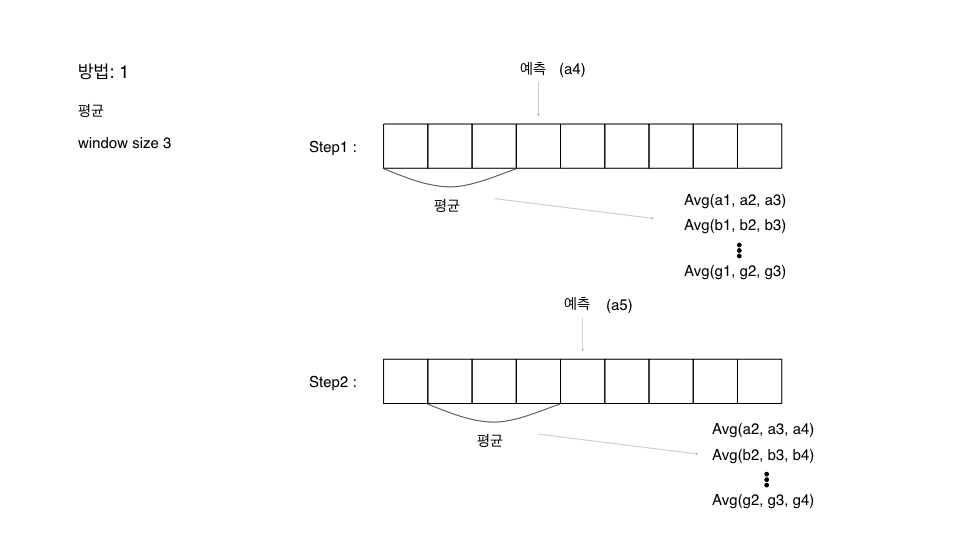

In [72]:
from PIL import Image

img = Image.open("sliding_window_1.jpeg").convert('L')
img

#### 5.1.2 flatten 방법 + 슬라이딩 윈도우

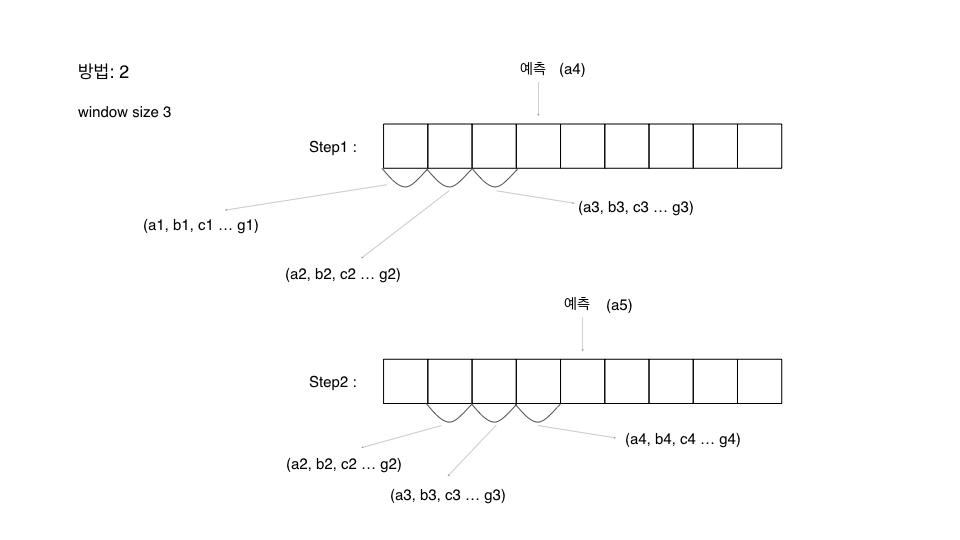

In [73]:
img = Image.open("sliding_window_2.jpeg").convert('L')
img

In [194]:
# 윈도우 크기에 따라 train, test 값의 결정 계수 반환해주는 함수
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def window_regression(window_size):

    n_window = df_norm.shape[0]-window_size+1
    X, Y = [], []

    for w in range(n_window - 1):
        X.append(df_norm[w:w+window_size])
        Y.append(df_power[w+window_size, 0])
    X, Y = np.asarray(X), np.asarray(Y)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

    X_train_f, X_test_f = [], []
    for r in range(X_train.shape[0]):
        X_train_f.append(X_train[r].flatten())
    for r in range(X_test.shape[0]):
        X_test_f.append(X_test[r].flatten())
    X_train_f, X_test_f = np.asarray(X_train_f), np.asarray(X_test_f)

    model = LinearRegression(fit_intercept=False)
    model = model.fit(X_train_f, Y_train)

    return model.score(X_train_f, Y_train), model.score(X_test_f, Y_test)

In [195]:
from tqdm.notebook import tqdm

train_rsq = []
test_rsq = []
for x in tqdm(range(2, 151)):
    a, b = window_regression(x)
    train_rsq.append(a)
    test_rsq.append(b)
train_rsq, test_rsq

([0.5504053714688495,
  0.5567150644853213,
  0.5612205012131655,
  0.5635943122899703,
  0.5616033033133176,
  0.5669650412015603,
  0.5703828051732803,
  0.5730641850398741,
  0.5801174674121476,
  0.5834325417400401,
  0.585442653367747,
  0.5866132473629512,
  0.5933096470805994,
  0.5884102631626889,
  0.593035246489767,
  0.5933452195834283,
  0.5925612100187505,
  0.5951218284335719,
  0.5905293495215421,
  0.5944645568038806,
  0.5967797593979676,
  0.6084198348016846,
  0.6110732020854965,
  0.611698536498431,
  0.6142957582822859,
  0.6165581037924961,
  0.6160460961490007,
  0.6167159804231603,
  0.6147020823224373,
  0.614415519130073,
  0.6149364722400685,
  0.6158241951046126,
  0.6166908247753845,
  0.6174418700421941,
  0.6194839112618669,
  0.6179151621094261,
  0.6169334288657427,
  0.6194141886532112,
  0.6228920702258786,
  0.6213833311856016,
  0.6192209012387373,
  0.6213294075899578,
  0.6220120421863344,
  0.6202034951820872,
  0.618904569682418,
  0.62335011033

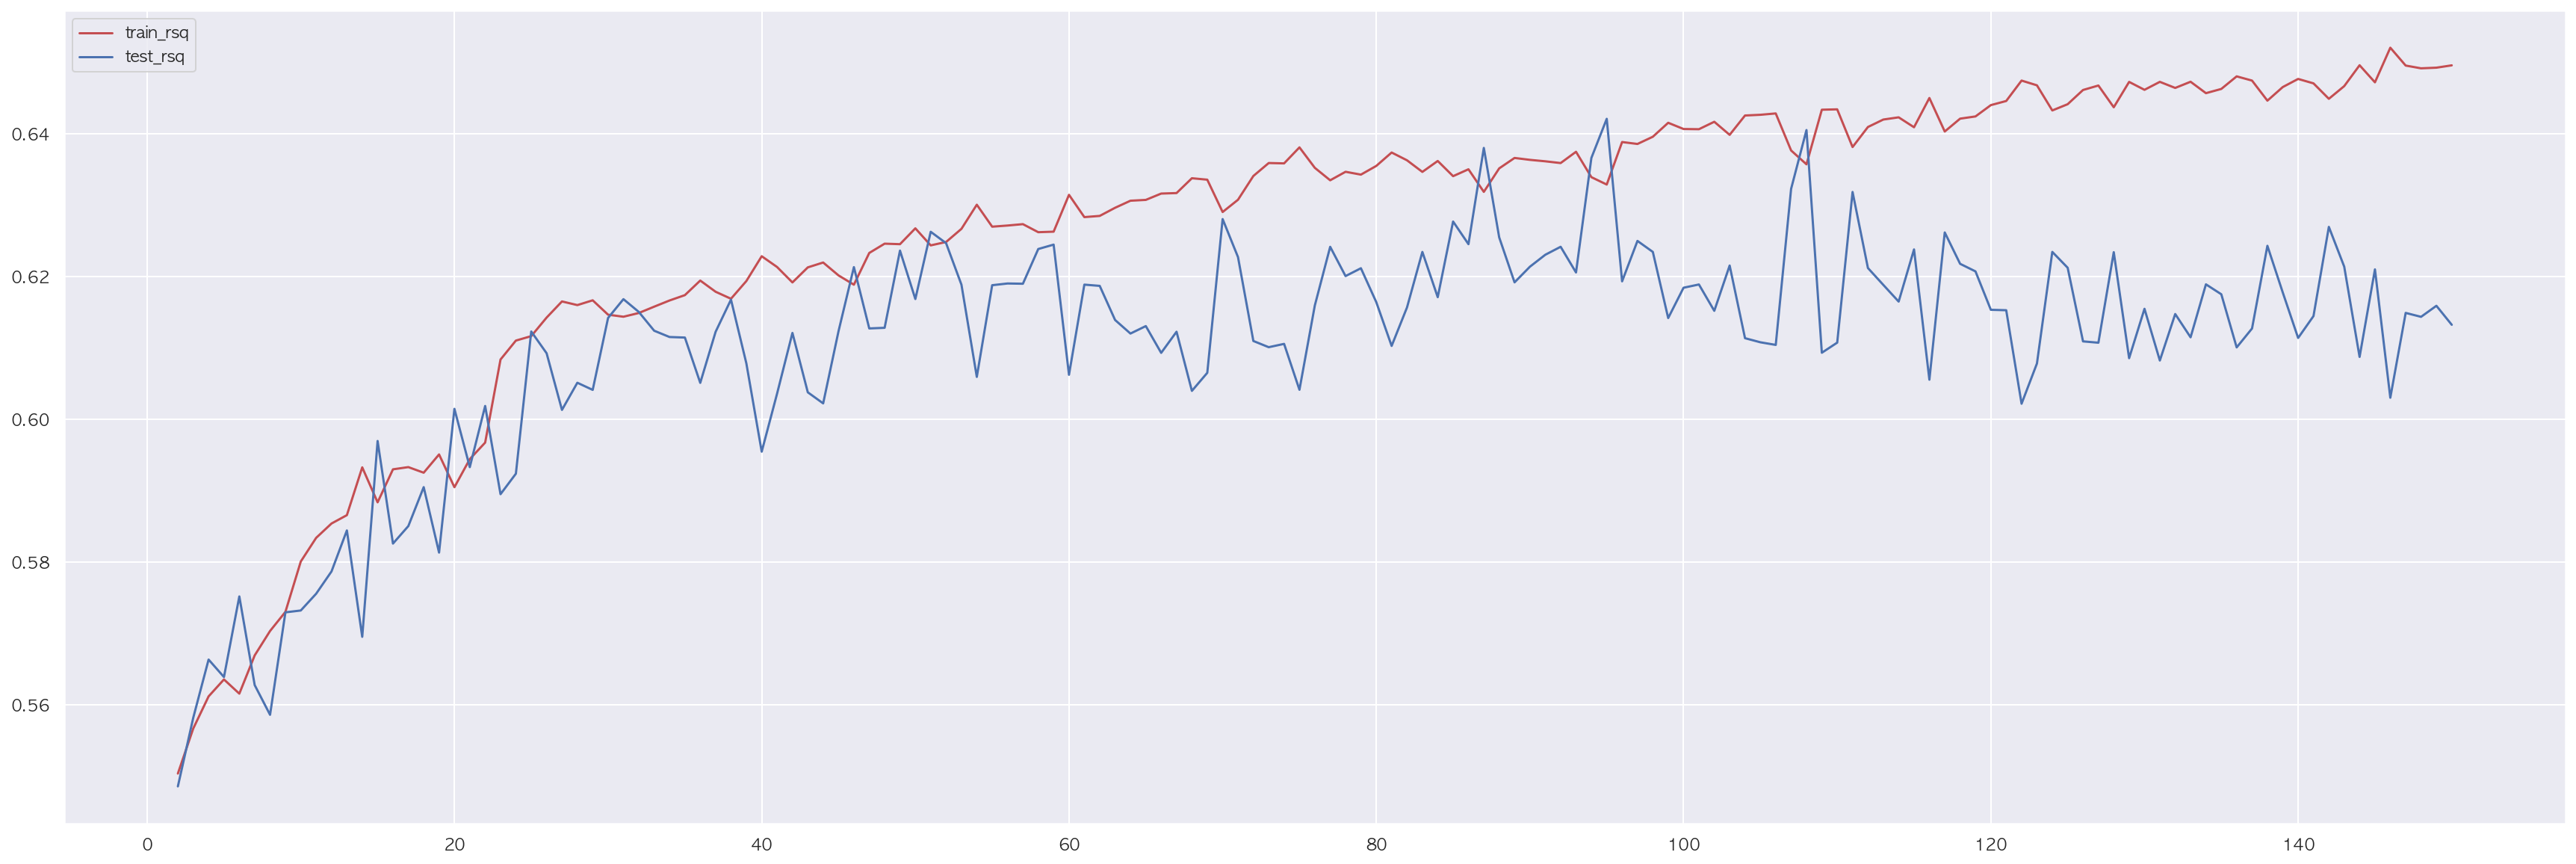

In [196]:
plt.figure(figsize = (30, 10))
x = np.linspace(2, 150, 149)

plt.plot(x, train_rsq, "r", label = "train_rsq")
plt.plot(x, test_rsq, "b", label = "test_rsq")

plt.legend()
plt.show()

In [ ]:
# 윈도우 사이즈가 커질수록 트레인, 테스트 데이터의 결정 계수 값이 함께 올라가다 일정 지점에서부터 차이를 보여주는 모습을 확인

In [197]:
for i in range(0, 20):
    print(train_rsq[100+i], test_rsq[100+i])
train_rsq[109], test_rsq[109]

0.6417317647151961 0.6152421571859399
0.6399005961313766 0.621587191268981
0.6426102629722539 0.6114093211145759
0.6427110268773725 0.6108350735247272
0.642899772004385 0.6104670356057202
0.6377107689603272 0.6323352524370469
0.635770964216668 0.6405731821370899
0.6434208814112157 0.6093677150553931
0.6434741416505259 0.6107861444578015
0.6381909264569828 0.631896393354231
0.6409985816911208 0.6212393583389598
0.6420436086710415 0.6188787064273429
0.6423548910496012 0.6165373870499
0.6409650668307132 0.6238467043145244
0.6450641484257766 0.6055909141133848
0.6403675509247269 0.6262224164032819
0.6421682865779257 0.6218300561537988
0.642479714743394 0.6207697682891986
0.6440647868618712 0.6153866601535822
0.644643342492182 0.6153267980372934


(0.6381909264569828, 0.631896393354231)

In [268]:
# 독립변수의 데이터를 윈도우 크기 109 만큼 선택

window_size = 109
n_window = df_norm.shape[0]-window_size+1
X, Y = [], []

for w in range(n_window - 1):
    X.append(df_norm[w:w+window_size])
    Y.append(df_power[w+window_size, 0])
X, Y = np.asarray(X), np.asarray(Y)

print(X.shape, Y.shape)

(34480, 109, 8) (34480,)


In [294]:
# 교차 검증 위해 트레인 데이터와 테스트 데이터 구분
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(27584, 109, 8) (6896, 109, 8) (27584,) (6896,)


In [295]:
# flatten 활용한 2차원 데이터 만들기
X_train_f, X_test_f = [], []

for r in range(X_train.shape[0]):
    X_train_f.append(X_train[r].flatten())

for r in range(X_test.shape[0]):
    X_test_f.append(X_test[r].flatten())

X_train_f, X_test_f = np.asarray(X_train_f), np.asarray(X_test_f)
X_train_f_df, X_test_f_df = pd.DataFrame(X_train_f), pd.DataFrame(X_test_f)

In [296]:
X_train_f_df

0         1         2         3         4         5         6    \
0      0.011745  0.121567  0.398581  0.015543  0.000000  0.008615  0.000000   
1      0.244640  0.099440  0.428822  0.237566  0.000000  0.000000  0.799691   
2      0.231936  0.140852  0.503225  0.225849  0.000000  0.004666  0.068059   
3      0.203645  0.099828  0.520348  0.194165  0.000000  0.000000  0.866203   
4      0.010720  0.080672  0.647837  0.013630  0.000000  0.003589  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
27579  0.133239  0.131468  0.652287  0.131516  0.171261  0.012204  0.078886   
27580  0.024278  0.132587  0.652524  0.026423  0.000000  0.003589  0.071926   
27581  0.349546  0.413259  0.459154  0.354974  0.262578  0.001436  0.880124   
27582  0.316739  0.354886  0.587468  0.307867  0.187112  0.031587  0.761794   
27583  0.022740  0.080456  0.606573  0.022716  0.000000  0.000000  0.000000   

            7         8         9    ...       862       863       864  \
0      0.024382  0.012170  0.135601  ...  0.000000  0.061703  0.023113   
1      0.152823  0.251626  0.117865  ...  0.830626  0.051031  0.190278   
2      0.376392  0.386145  0.075506  ...  0.210363  0.153400  0.235815   
3      0.060933  0.102648  0.113000  ...  0.460170  0.361885  0.092990   
4      0.026325  0.072213  0.193328  ...  0.190255  0.074713  0.096921   
...         ...       ...       ...  ...       ...       ...       ...   
27579  0.069819  0.064445  0.117908  ...  0.074246  0.184112  0.126367   
27580  0.024820  0.026412  0.150452  ...  0.071926  0.038880  0.115880   
27581  0.101669  0.121121  0.260353  ...  0.075019  0.124466  0.043543   
27582  0.121848  0.251554  0.164787  ...  0.030936  0.082435  0.060151   
27583  0.049272  0.028281  0.144124  ...  0.000000  0.051145  0.021000   

            865       866       867       868       869       870       871  
0      0.081489  0.438995  0.027977  0.000000  0.000000  0.000000  0.049902  
1      0.085579  0.522957  0.181133  0.000000  0.000000  0.815932  0.055409  
2      0.183728  0.525009  0.232903  0.180221  0.133884  0.029389  0.164169  
3      0.134309  0.446354  0.091105  0.000000  0.008615  0.150039  0.110774  
4      0.438786  0.591292  0.112386  0.000000  0.085068  0.000000  0.112428  
...         ...       ...       ...       ...       ...       ...       ...  
27579  0.084115  0.540667  0.124582  0.000000  0.005743  0.030936  0.209746  
27580  0.132329  0.582207  0.113462  0.000000  0.000000  0.072699  0.182037  
27581  0.205037  0.639347  0.050096  0.000000  0.011486  0.072699  0.051346  
27582  0.156780  0.521256  0.060617  0.000000  0.007179  0.167053  0.050532  
27583  0.068403  0.520284  0.020206  0.000000  0.000000  0.000000  0.046330  

[27584 rows x 872 columns]

In [297]:
Y_train_df = pd.DataFrame(Y_train)
Y_train_df.columns = ["active_power_y"]

df_train = pd.concat([X_train_f_df, Y_train_df], axis=1)
df_train

0         1         2         3         4         5         6  \
0      0.011745  0.121567  0.398581  0.015543  0.000000  0.008615  0.000000   
1      0.244640  0.099440  0.428822  0.237566  0.000000  0.000000  0.799691   
2      0.231936  0.140852  0.503225  0.225849  0.000000  0.004666  0.068059   
3      0.203645  0.099828  0.520348  0.194165  0.000000  0.000000  0.866203   
4      0.010720  0.080672  0.647837  0.013630  0.000000  0.003589  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
27579  0.133239  0.131468  0.652287  0.131516  0.171261  0.012204  0.078886   
27580  0.024278  0.132587  0.652524  0.026423  0.000000  0.003589  0.071926   
27581  0.349546  0.413259  0.459154  0.354974  0.262578  0.001436  0.880124   
27582  0.316739  0.354886  0.587468  0.307867  0.187112  0.031587  0.761794   
27583  0.022740  0.080456  0.606573  0.022716  0.000000  0.000000  0.000000   

              7         8         9  ...       863       864       865  \
0      0.024382  0.012170  0.135601  ...  0.061703  0.023113  0.081489   
1      0.152823  0.251626  0.117865  ...  0.051031  0.190278  0.085579   
2      0.376392  0.386145  0.075506  ...  0.153400  0.235815  0.183728   
3      0.060933  0.102648  0.113000  ...  0.361885  0.092990  0.134309   
4      0.026325  0.072213  0.193328  ...  0.074713  0.096921  0.438786   
...         ...       ...       ...  ...       ...       ...       ...   
27579  0.069819  0.064445  0.117908  ...  0.184112  0.126367  0.084115   
27580  0.024820  0.026412  0.150452  ...  0.038880  0.115880  0.132329   
27581  0.101669  0.121121  0.260353  ...  0.124466  0.043543  0.205037   
27582  0.121848  0.251554  0.164787  ...  0.082435  0.060151  0.156780   
27583  0.049272  0.028281  0.144124  ...  0.051145  0.021000  0.068403   

            866       867       868       869       870       871  \
0      0.438995  0.027977  0.000000  0.000000  0.000000  0.049902   
1      0.522957  0.181133  0.000000  0.000000  0.815932  0.055409   
2      0.525009  0.232903  0.180221  0.133884  0.029389  0.164169   
3      0.446354  0.091105  0.000000  0.008615  0.150039  0.110774   
4      0.591292  0.112386  0.000000  0.085068  0.000000  0.112428   
...         ...       ...       ...       ...       ...       ...   
27579  0.540667  0.124582  0.000000  0.005743  0.030936  0.209746   
27580  0.582207  0.113462  0.000000  0.000000  0.072699  0.182037   
27581  0.639347  0.050096  0.000000  0.011486  0.072699  0.051346   
27582  0.521256  0.060617  0.000000  0.007179  0.167053  0.050532   
27583  0.520284  0.020206  0.000000  0.000000  0.000000  0.046330   

       active_power_y  
0            0.698533  
1            1.343767  
2            2.625600  
3            0.444600  
4            0.583333  
...               ...  
27579        0.885267  
27580        1.242000  
27581        0.326867  
27582        1.588500  
27583        0.329200  

[27584 rows x 873 columns]

### 5.2 슬라이딩 윈도우 이후 상관관계 확인

In [298]:
df_corr = df_train.corr()
df_corr

0         1         2         3         4         5  \
0               1.000000  0.312208 -0.371765  0.999418  0.494955  0.436252   
1               0.312208  1.000000 -0.143332  0.328338  0.328637  0.255566   
2              -0.371765 -0.143332  1.000000 -0.385182 -0.206020 -0.157189   
3               0.999418  0.328338 -0.385182  1.000000  0.503478  0.443390   
4               0.494955  0.328637 -0.206020  0.503478  1.000000  0.111919   
...                  ...       ...       ...       ...       ...       ...   
868             0.021882 -0.055326 -0.013779  0.020474 -0.008846 -0.020386   
869            -0.050067 -0.057723  0.054659 -0.050795 -0.026082 -0.027950   
870             0.148542 -0.008083  0.019684  0.146161  0.062960 -0.023701   
871             0.210278 -0.102205 -0.044463  0.206592  0.020731 -0.012908   
active_power_y  0.156464 -0.088580  0.017848  0.153259  0.011337 -0.045185   

                       6         7         8         9  ...       863  \
0               0.695233  0.754044  0.713489  0.199900  ...  0.231582   
1               0.104654  0.201176  0.236502  0.485822  ... -0.094328   
2              -0.274455 -0.259350 -0.278909 -0.121478  ... -0.072758   
3               0.685598  0.754330  0.713685  0.209005  ...  0.227579   
4               0.194900  0.237644  0.295144  0.228022  ...  0.048240   
...                  ...       ...       ...       ...  ...       ...   
868             0.050333  0.008786  0.010009 -0.060498  ...  0.230990   
869            -0.043625 -0.026326 -0.052024 -0.062371  ...  0.103805   
870             0.049406  0.208646  0.091943 -0.050557  ...  0.242775   
871             0.193949  0.204179  0.233778 -0.093648  ...  0.761385   
active_power_y  0.069815  0.237496  0.183690 -0.089911  ...  0.434428   

                     864       865       866       867       868       869  \
0               0.180902 -0.084868 -0.007596  0.176508  0.021882 -0.050067   
1              -0.089670  0.054865  0.001501 -0.087831 -0.055326 -0.057723   
2              -0.002764  0.016073  0.375476 -0.008569 -0.013779  0.054659   
3               0.177151 -0.083244 -0.013847  0.172961  0.020474 -0.050795   
4               0.033239 -0.047640 -0.020353  0.031730 -0.008846 -0.026082   
...                  ...       ...       ...       ...       ...       ...   
868             0.493940  0.329670 -0.205561  0.502410  1.000000  0.113202   
869             0.438149  0.254933 -0.158502  0.445470  0.113202  1.000000   
870             0.697269  0.103476 -0.273218  0.687598  0.193878  0.125797   
871             0.752853  0.198315 -0.263406  0.753155  0.238345  0.125011   
active_power_y  0.714567  0.235280 -0.282618  0.714798  0.296092  0.253507   

                     870       871  active_power_y  
0               0.148542  0.210278        0.156464  
1              -0.008083 -0.102205       -0.088580  
2               0.019684 -0.044463        0.017848  
3               0.146161  0.206592        0.153259  
4               0.062960  0.020731        0.011337  
...                  ...       ...             ...  
868             0.193878  0.238345        0.296092  
869             0.125797  0.125011        0.253507  
870             1.000000  0.220053        0.455373  
871             0.220053  1.000000        0.630619  
active_power_y  0.455373  0.630619        1.000000  

[873 rows x 873 columns]

In [204]:
df_corr2 = df_corr.copy()

for a in range(0, 872):
    for b in range(0, 872):
        if 0.7 <= abs(df_corr.iloc[a, b]) < 1:
            df_corr2.iloc[a, b] = "nan"
df_corr2

0         1          2          3         4         5  \
0                       1  0.312208  -0.371765        nan  0.494955  0.436252   
1                0.312208  1.000000  -0.143332   0.328338  0.328637  0.255566   
2               -0.371765 -0.143332          1  -0.385182 -0.206020 -0.157189   
3                     nan  0.328338  -0.385182          1  0.503478  0.443390   
4                0.494955  0.328637   -0.20602   0.503478  1.000000  0.111919   
...                   ...       ...        ...        ...       ...       ...   
868             0.0218825 -0.055326 -0.0137787  0.0204736 -0.008846 -0.020386   
869             -0.050067 -0.057723  0.0546589 -0.0507952 -0.026082 -0.027950   
870              0.148542 -0.008083  0.0196836   0.146161  0.062960 -0.023701   
871              0.210278 -0.102205 -0.0444634   0.206592  0.020731 -0.012908   
active_power_y   0.156464 -0.088580  0.0178484   0.153259  0.011337 -0.045185   

                       6          7          8         9  ...        863  \
0               0.695233        nan        nan  0.199900  ...   0.231582   
1               0.104654   0.201176   0.236502  0.485822  ... -0.0943285   
2              -0.274455   -0.25935  -0.278909 -0.121478  ... -0.0727584   
3               0.685598        nan        nan  0.209005  ...   0.227579   
4               0.194900   0.237644   0.295144  0.228022  ...    0.04824   
...                  ...        ...        ...       ...  ...        ...   
868             0.050333  0.0087862  0.0100085 -0.060498  ...    0.23099   
869            -0.043625 -0.0263261 -0.0520239 -0.062371  ...   0.103805   
870             0.049406   0.208646  0.0919427 -0.050557  ...   0.242775   
871             0.193949   0.204179   0.233778 -0.093648  ...        nan   
active_power_y  0.069815   0.237496    0.18369 -0.089911  ...   0.434428   

                       864       865         866         867       868  \
0                 0.180902 -0.084868 -0.00759552    0.176508  0.021882   
1               -0.0896703  0.054865  0.00150054  -0.0878314 -0.055326   
2              -0.00276372  0.016073    0.375476 -0.00856917 -0.013779   
3                 0.177151 -0.083244  -0.0138473    0.172961  0.020474   
4                0.0332391 -0.047640  -0.0203534   0.0317297 -0.008846   
...                    ...       ...         ...         ...       ...   
868                0.49394  0.329670   -0.205561     0.50241  1.000000   
869               0.438149  0.254933   -0.158502     0.44547  0.113202   
870               0.697269  0.103476   -0.273218    0.687598  0.193878   
871                    nan  0.198315   -0.263406         nan  0.238345   
active_power_y    0.714567  0.235280   -0.282618    0.714798  0.296092   

                     869       870        871 active_power_y  
0              -0.050067  0.148542   0.210278       0.156464  
1              -0.057723 -0.008083  -0.102205      -0.088580  
2               0.054659  0.019684 -0.0444634       0.017848  
3              -0.050795  0.146161   0.206592       0.153259  
4              -0.026082  0.062960  0.0207306       0.011337  
...                  ...       ...        ...            ...  
868             0.113202  0.193878   0.238345       0.296092  
869             1.000000  0.125797   0.125011       0.253507  
870             0.125797  1.000000   0.220053       0.455373  
871             0.125011  0.220053          1       0.630619  
active_power_y  0.253507  0.455373   0.630619       1.000000  

[873 rows x 873 columns]

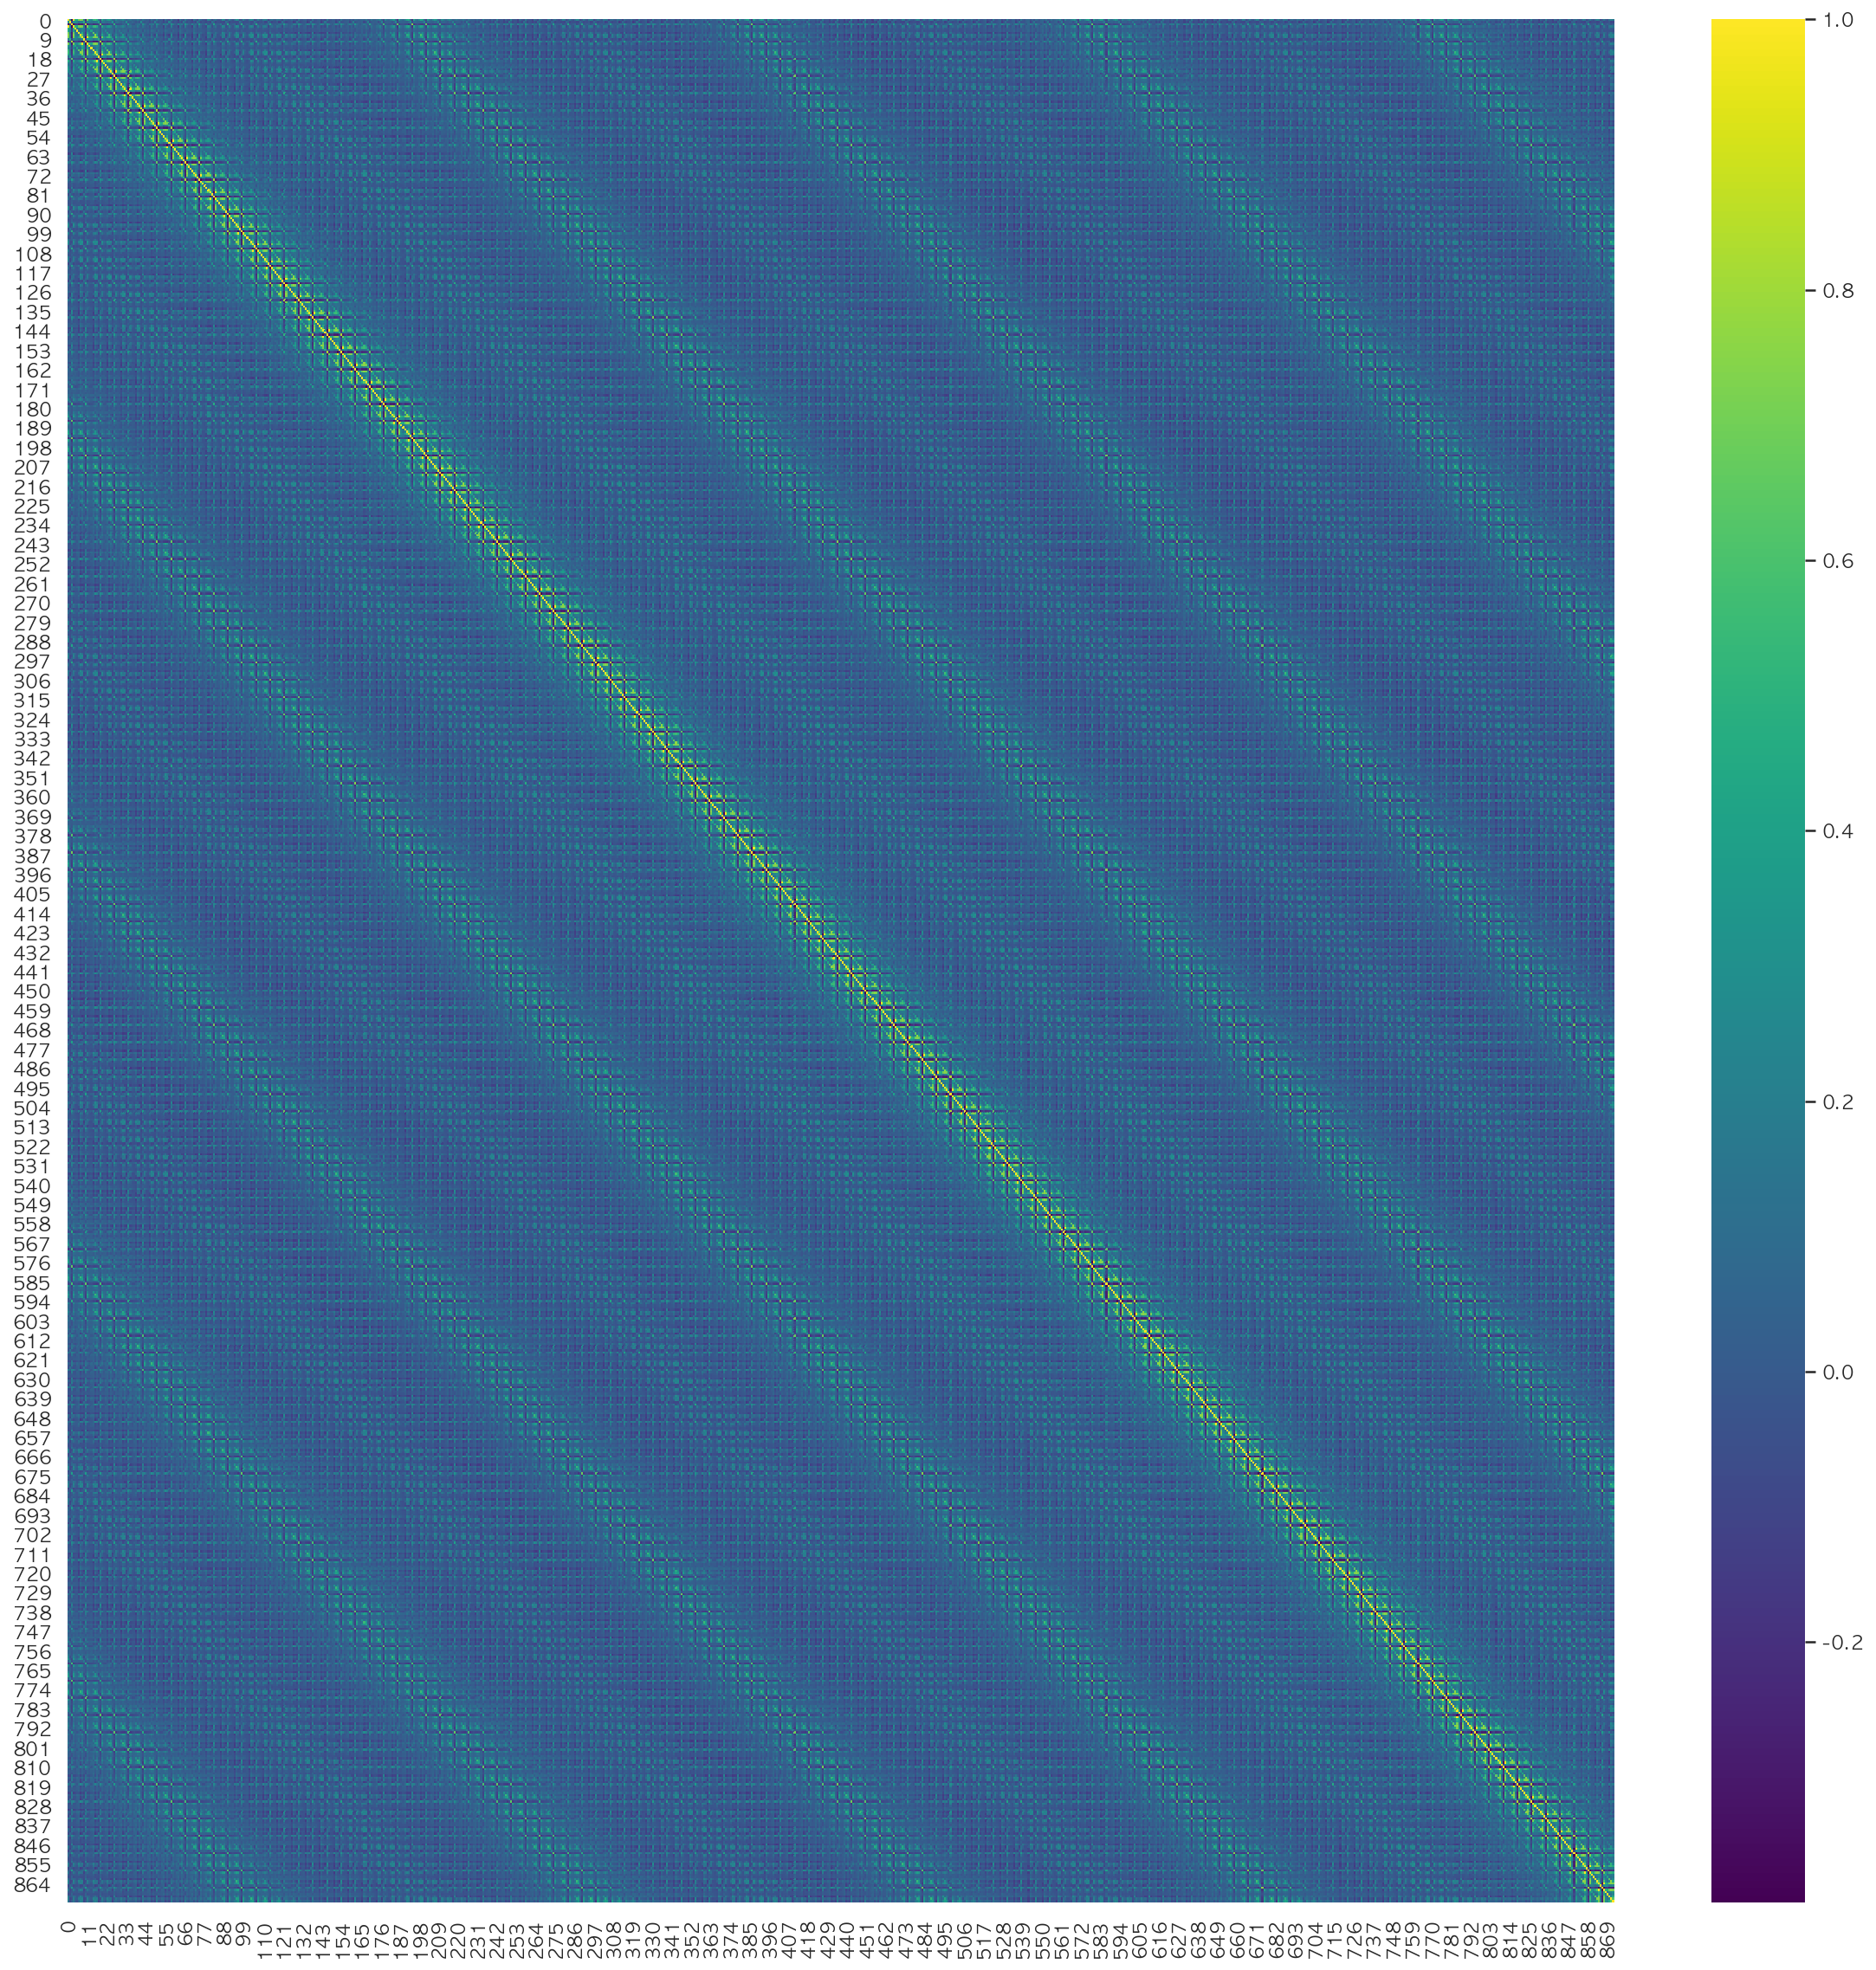

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20, 20))
sns.heatmap(df_corr, cmap="viridis")
plt.show()

### 5.3 차원 축소(PCA)

In [299]:
# 표준화
# 다중공선성 문제를 해결하기 위해 차원 축소
# 같은 변수명을 가지고 있는 컬럼끼리 모아 차원 축소

from sklearn.decomposition import PCA

pca = PCA(n_components=14) # 15 이상부터는 다중공선성 경고가 뜬다
X_train_pca = pd.DataFrame()

for i in range(8):
    #fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
    col_range = [i + (8 * x) for x in range(109)]
    x_pca = pca.fit_transform(X_train_f_df.iloc[:, col_range])
    X_train_pca = pd.concat([X_train_pca, pd.DataFrame(x_pca)], axis=1)
X_train_pca.columns = ["active_power1", "reactive_power1", "Voltage1", "intensity1", "Sub_metering1_1", "Sub_metering1_2", "Sub_metering1_3", "Sub_metering1_4" \
                       , "active_power2", "reactive_power2", "Voltage2", "intensity2", "Sub_metering2_1", "Sub_metering2_2", "Sub_metering2_3", "Sub_metering2_4" \
                       , "active_power3", "reactive_power3", "Voltage3", "intensity3", "Sub_metering3_1", "Sub_metering3_2", "Sub_metering3_3", "Sub_metering3_4" \
                       , "active_power4", "reactive_power4", "Voltage4", "intensity4", "Sub_metering4_1", "Sub_metering4_2", "Sub_metering4_3", "Sub_metering4_4" \
                       , "active_power5", "reactive_power5", "Voltage5", "intensity5", "Sub_metering5_1", "Sub_metering5_2", "Sub_metering5_3", "Sub_metering5_4" \
                       , "active_power6", "reactive_power6", "Voltage6", "intensity6", "Sub_metering6_1", "Sub_metering6_2", "Sub_metering6_3", "Sub_metering6_4" \
                       , "active_power7", "reactive_power7", "Voltage7", "intensity7", "Sub_metering7_1", "Sub_metering7_2", "Sub_metering7_3", "Sub_metering7_4" \
                       , "active_power8", "reactive_power8", "Voltage8", "intensity8", "Sub_metering8_1", "Sub_metering8_2", "Sub_metering8_3", "Sub_metering8_4" \
                       , "active_power9", "reactive_power9", "Voltage9", "intensity9", "Sub_metering9_1", "Sub_metering9_2", "Sub_metering9_3", "Sub_metering9_4" \
                       , "active_power10", "reactive_power10", "Voltage10", "intensity10", "Sub_metering10_1", "Sub_metering10_2", "Sub_metering10_3", "Sub_metering10_4" \
                       , "active_power11", "reactive_power11", "Voltage11", "intensity11_3", "Sub_metering11_1", "Sub_metering11_2", "Sub_metering11_3", "Sub_metering11_4" \
                       , "active_power12", "reactive_power12", "Voltage12", "intensity12", "Sub_metering12_1", "Sub_metering12_2", "Sub_metering12_3", "Sub_metering12_4" \
                       , "active_power13", "reactive_power13", "Voltage13", "intensity13", "Sub_metering13_1", "Sub_metering13_2", "Sub_metering13_3", "Sub_metering13_4" \
                       , "active_power14", "reactive_power14", "Voltage14", "intensity14", "Sub_metering14_1", "Sub_metering14_2", "Sub_metering14_3", "Sub_metering14_4"]
X_train_pca


# 차원 축소를 독립변수 8개 기준의 행별로 해보았으나 결정계수가  0.173으로 매우 낮게 나옴
# i = 1
# list(range((8*i), (8+(8*i))))

# from sklearn.decomposition import PCA

# pca = PCA(n_components=1)
# X_train_pca = pd.DataFrame()

# for i in range(32):
#     #fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
#     x_pca = pca.fit_transform(X_train_f.iloc[:, list(range((8*i), (8+(8*i))))]) 
#     X_train_pca = pd.concat([X_train_pca, pd.DataFrame(x_pca)], axis=1)
# X_train_pca.columns = ["active_power1", "reactive_power1", "Voltage1", "intensity1", "Sub_metering_11", "Sub_metering_12", "Sub_metering_13", "Sub_metering_14" \
#                        , "active_power2", "reactive_power2", "Voltage2", "intensity2", "Sub_metering_21", "Sub_metering_22", "Sub_metering_23", "Sub_metering_24" \
#                        , "active_power3", "reactive_power3", "Voltage3", "intensity3", "Sub_metering_31", "Sub_metering_32", "Sub_metering_33", "Sub_metering_34" \
#                        , "active_power4", "reactive_power4", "Voltage4", "intensity4", "Sub_metering_41", "Sub_metering_42", "Sub_metering_43", "Sub_metering_44"]
# X_train_pca

active_power1  reactive_power1  Voltage1  intensity1  Sub_metering1_1  \
0          -0.573695         0.457735 -0.224337    0.041916         0.334193   
1           0.133087        -0.558437 -0.276750   -0.036293         0.435886   
2           0.042675        -0.398828  0.194353   -0.280706         0.730228   
3           0.380204        -0.527948  0.113951    0.216092        -0.469630   
4          -0.686148         0.402785  0.115549    0.259460         0.071658   
...              ...              ...       ...         ...              ...   
27579       0.039392         0.226588 -0.523165   -0.213586        -0.069328   
27580      -0.413431        -0.192454  0.297128    0.047671         0.093471   
27581      -0.030929        -0.206639 -0.301094   -0.299657        -0.253653   
27582      -0.235967        -0.201022  0.374002    0.067178         0.348500   
27583      -0.887684        -0.010186 -0.218107   -0.026012        -0.184769   

       Sub_metering1_2  Sub_metering1_3  Sub_metering1_4  active_power2  \
0             0.154282         0.219373        -0.089459      -0.224882   
1             0.183350        -0.134355        -0.058261       0.019246   
2            -0.032513         0.105414         0.105310      -0.341126   
3             0.583730         0.397577        -0.129967       0.213547   
4            -0.127682         0.024925        -0.026515      -0.045857   
...                ...              ...              ...            ...   
27579         0.204151        -0.121345        -0.150333      -0.228440   
27580         0.020229         0.036651         0.081873      -0.123569   
27581         0.173920        -0.286114         0.118244      -0.249647   
27582         0.062680        -0.058076         0.015831      -0.019926   
27583         0.224311         0.011364         0.091141      -0.194927   

       reactive_power2  ...  Sub_metering13_3  Sub_metering13_4  \
0             0.078567  ...          0.265730          0.139253   
1             0.155117  ...          0.036144          0.079581   
2             0.118695  ...         -0.079163         -0.180551   
3            -0.226692  ...          0.186982          0.333169   
4             0.323521  ...          0.234192         -0.136128   
...                ...  ...               ...               ...   
27579        -0.177533  ...         -0.318214          0.113315   
27580        -0.156093  ...          0.581042         -0.140418   
27581        -0.181806  ...         -0.125015         -0.004771   
27582         0.164078  ...         -0.034374          0.107445   
27583        -0.009238  ...         -0.125656          0.159860   

       active_power14  reactive_power14  Voltage14  intensity14  \
0            0.263673         -0.086625   0.028719     0.232902   
1           -0.080380          0.092625  -0.062876     0.105153   
2           -0.045097          0.098463  -0.014083    -0.187869   
3            0.268196         -0.148391  -0.221377     0.106944   
4            0.012865         -0.115192   0.045126     0.064586   
...               ...               ...        ...          ...   
27579       -0.102672         -0.108830   0.213580    -0.186988   
27580        0.092625         -0.070867  -0.069851    -0.240106   
27581       -0.055451         -0.047433   0.091508     0.182179   
27582       -0.094359          0.004698   0.111531     0.105099   
27583        0.008820          0.071004   0.014736    -0.110720   

       Sub_metering14_1  Sub_metering14_2  Sub_metering14_3  Sub_metering14_4  
0             -0.107216         -0.072255         -0.249641         -0.023475  
1              0.249907          0.032592          0.228181          0.113561  
2             -0.101927         -0.128410          0.111219          0.000464  
3              0.155585         -0.112465         -0.137556         -0.129301  
4              0.025700         -0.058119         -0.000297         -0.069660  
...                 ...               ...              

In [300]:
Y_train_df

active_power_y
0            0.698533
1            1.343767
2            2.625600
3            0.444600
4            0.583333
...               ...
27579        0.885267
27580        1.242000
27581        0.326867
27582        1.588500
27583        0.329200

[27584 rows x 1 columns]

In [301]:
df_train2 = pd.concat([X_train_pca, Y_train_df], axis=1)
df_train2

active_power1  reactive_power1  Voltage1  intensity1  Sub_metering1_1  \
0          -0.573695         0.457735 -0.224337    0.041916         0.334193   
1           0.133087        -0.558437 -0.276750   -0.036293         0.435886   
2           0.042675        -0.398828  0.194353   -0.280706         0.730228   
3           0.380204        -0.527948  0.113951    0.216092        -0.469630   
4          -0.686148         0.402785  0.115549    0.259460         0.071658   
...              ...              ...       ...         ...              ...   
27579       0.039392         0.226588 -0.523165   -0.213586        -0.069328   
27580      -0.413431        -0.192454  0.297128    0.047671         0.093471   
27581      -0.030929        -0.206639 -0.301094   -0.299657        -0.253653   
27582      -0.235967        -0.201022  0.374002    0.067178         0.348500   
27583      -0.887684        -0.010186 -0.218107   -0.026012        -0.184769   

       Sub_metering1_2  Sub_metering1_3  Sub_metering1_4  active_power2  \
0             0.154282         0.219373        -0.089459      -0.224882   
1             0.183350        -0.134355        -0.058261       0.019246   
2            -0.032513         0.105414         0.105310      -0.341126   
3             0.583730         0.397577        -0.129967       0.213547   
4            -0.127682         0.024925        -0.026515      -0.045857   
...                ...              ...              ...            ...   
27579         0.204151        -0.121345        -0.150333      -0.228440   
27580         0.020229         0.036651         0.081873      -0.123569   
27581         0.173920        -0.286114         0.118244      -0.249647   
27582         0.062680        -0.058076         0.015831      -0.019926   
27583         0.224311         0.011364         0.091141      -0.194927   

       reactive_power2  ...  Sub_metering13_4  active_power14  \
0             0.078567  ...          0.139253        0.263673   
1             0.155117  ...          0.079581       -0.080380   
2             0.118695  ...         -0.180551       -0.045097   
3            -0.226692  ...          0.333169        0.268196   
4             0.323521  ...         -0.136128        0.012865   
...                ...  ...               ...             ...   
27579        -0.177533  ...          0.113315       -0.102672   
27580        -0.156093  ...         -0.140418        0.092625   
27581        -0.181806  ...         -0.004771       -0.055451   
27582         0.164078  ...          0.107445       -0.094359   
27583        -0.009238  ...          0.159860        0.008820   

       reactive_power14  Voltage14  intensity14  Sub_metering14_1  \
0             -0.086625   0.028719     0.232902         -0.107216   
1              0.092625  -0.062876     0.105153          0.249907   
2              0.098463  -0.014083    -0.187869         -0.101927   
3             -0.148391  -0.221377     0.106944          0.155585   
4             -0.115192   0.045126     0.064586          0.025700   
...                 ...        ...          ...               ...   
27579         -0.108830   0.213580    -0.186988         -0.024524   
27580         -0.070867  -0.069851    -0.240106          0.120523   
27581         -0.047433   0.091508     0.182179         -0.039791   
27582          0.004698   0.111531     0.105099         -0.097442   
27583          0.071004   0.014736    -0.110720          0.010672   

       Sub_metering14_2  Sub_metering14_3  Sub_metering14_4  active_power_y  
0             -0.072255         -0.249641         -0.023475        0.698533  
1              0.032592          0.228181          0.113561        1.343767  
2             -0.128410          0.111219          0.000464        2.625600  
3             -0.112465         -0.137556         -0.129301        0.444600  
4             -0.058119         -0.000297         -0.069660        0.583333  
...                 ...               ...               ...        

## 5. 회귀분석

In [302]:
import statsmodels.api as sm

feature_names = list(df_train2[ : 0])
feature_names.remove("active_power_y")

formula = "active_power_y ~ " + "+".join(feature_names)
model1 = sm.OLS.from_formula(formula, data = df_train2)
result1 = model1.fit()

print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:         active_power_y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     241.3
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:43:39   Log-Likelihood:                -26575.
No. Observations:               27584   AIC:                         5.338e+04
Df Residuals:                   27471   BIC:                         5.430e+04
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0863      0.004  

### 5.1 피처 선택

In [303]:
### 유의확률이 유의수준 10%를 초과하는 독립변수(종속변수에 크게 영향 주지 않는) 모두 제거
feature_names = list(df_train2[ : 0])
feature_names.remove("active_power_y") # 종속변수 제거

# 1: 0.9 이상
feature_names.remove("Sub_metering4_3")
feature_names.remove("Sub_metering12_3")

# 2: 0.8 이상
feature_names.remove("Sub_metering6_4")

# 3: 0.5 이상
feature_names.remove("Sub_metering6_2")
feature_names.remove("Sub_metering13_1")
feature_names.remove("Sub_metering13_4")

# 4: 0.4 이상
feature_names.remove("Voltage4")
feature_names.remove("Sub_metering5_1")
feature_names.remove("Voltage14")

# 5: 0.01 이상
feature_names.remove("reactive_power1")
feature_names.remove("reactive_power3")
feature_names.remove("Voltage3")
feature_names.remove("intensity3")
feature_names.remove("Sub_metering3_3")
feature_names.remove("reactive_power5")
feature_names.remove("intensity5")
feature_names.remove("Sub_metering5_4")
feature_names.remove("Voltage6")
feature_names.remove("intensity6")
feature_names.remove("Voltage7")
feature_names.remove("intensity8")
feature_names.remove("Sub_metering8_2")
feature_names.remove("Sub_metering8_4")
feature_names.remove("intensity9")
feature_names.remove("intensity10")
feature_names.remove("Sub_metering10_4")
feature_names.remove("intensity12")
feature_names.remove("reactive_power13")
feature_names.remove("reactive_power14")
feature_names.remove("Sub_metering14_1")

formula = "active_power_y ~ " + "+".join(feature_names)
model2 = sm.OLS.from_formula(formula, data = df_train2)
result2 = model2.fit()

print(result2.summary())

# "active_power_y", "reactive_power1", "intensity1", "Sub_metering1_3", "reactive_power3", "Voltage3", "Sub_metering3_3", "Sub_metering3_4 "\
# , "Sub_metering4_3", "reactive_power6", "intensity6", "Sub_metering6_2", "active_power8", "reactive_power8", "Sub_metering8_1"\
# , "Sub_metering8_2", "Sub_metering8_4", "Sub_metering9_1", "Sub_metering9_3", "Sub_metering9_4", "intensity10", "Voltage11"\
# , "Sub_metering11_1", "Sub_metering11_2", "Sub_metering12_4", "intensity13", "Sub_metering13_2", "Sub_metering14_1", "Sub_metering14_3"

                            OLS Regression Results                            
Dep. Variable:         active_power_y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     315.3
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:43:44   Log-Likelihood:                -26881.
No. Observations:               27584   AIC:                         5.393e+04
Df Residuals:                   27501   BIC:                         5.461e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0863      0.004  

## 6. 교차 검증

In [151]:
X_test_f.shape

(6896, 872)

In [304]:
# 표준화
from sklearn.decomposition import PCA

pca = PCA(n_components=14) # 15 이상부터는 다중공선성 경고가 뜬다
X_test_pca = pd.DataFrame()

for i in range(8):
    #fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
    col_range = [i + (8 * x) for x in range(109)]
    x_pca = pca.fit_transform(X_test_f_df.iloc[:, col_range]) 
    X_test_pca = pd.concat([X_test_pca, pd.DataFrame(x_pca)], axis=1)
X_test_pca.columns = ["active_power1", "reactive_power1", "Voltage1", "intensity1", "Sub_metering1_1", "Sub_metering1_2", "Sub_metering1_3", "Sub_metering1_4" \
                       , "active_power2", "reactive_power2", "Voltage2", "intensity2", "Sub_metering2_1", "Sub_metering2_2", "Sub_metering2_3", "Sub_metering2_4" \
                       , "active_power3", "reactive_power3", "Voltage3", "intensity3", "Sub_metering3_1", "Sub_metering3_2", "Sub_metering3_3", "Sub_metering3_4" \
                       , "active_power4", "reactive_power4", "Voltage4", "intensity4", "Sub_metering4_1", "Sub_metering4_2", "Sub_metering4_3", "Sub_metering4_4" \
                       , "active_power5", "reactive_power5", "Voltage5", "intensity5", "Sub_metering5_1", "Sub_metering5_2", "Sub_metering5_3", "Sub_metering5_4" \
                       , "active_power6", "reactive_power6", "Voltage6", "intensity6", "Sub_metering6_1", "Sub_metering6_2", "Sub_metering6_3", "Sub_metering6_4" \
                       , "active_power7", "reactive_power7", "Voltage7", "intensity7", "Sub_metering7_1", "Sub_metering7_2", "Sub_metering7_3", "Sub_metering7_4" \
                       , "active_power8", "reactive_power8", "Voltage8", "intensity8", "Sub_metering8_1", "Sub_metering8_2", "Sub_metering8_3", "Sub_metering8_4" \
                       , "active_power9", "reactive_power9", "Voltage9", "intensity9", "Sub_metering9_1", "Sub_metering9_2", "Sub_metering9_3", "Sub_metering9_4" \
                       , "active_power10", "reactive_power10", "Voltage10", "intensity10", "Sub_metering10_1", "Sub_metering10_2", "Sub_metering10_3", "Sub_metering10_4" \
                       , "active_power11", "reactive_power11", "Voltage11", "intensity11_3", "Sub_metering11_1", "Sub_metering11_2", "Sub_metering11_3", "Sub_metering11_4" \
                       , "active_power12", "reactive_power12", "Voltage12", "intensity12", "Sub_metering12_1", "Sub_metering12_2", "Sub_metering12_3", "Sub_metering12_4" \
                       , "active_power13", "reactive_power13", "Voltage13", "intensity13", "Sub_metering13_1", "Sub_metering13_2", "Sub_metering13_3", "Sub_metering13_4" \
                       , "active_power14", "reactive_power14", "Voltage14", "intensity14", "Sub_metering14_1", "Sub_metering14_2", "Sub_metering14_3", "Sub_metering14_4"]
X_test_pca

active_power1  reactive_power1  Voltage1  intensity1  Sub_metering1_1  \
0         -0.363415        -0.164040 -0.803868    0.039755        -0.079617   
1         -0.414430        -0.368699 -0.252937    0.141381        -0.146515   
2          0.338936        -0.073993 -0.282992   -0.377272        -0.078450   
3         -0.322282        -0.274572 -0.322985    0.216770        -0.093659   
4          0.521820        -0.740139 -0.333482   -0.591096        -0.274370   
...             ...              ...       ...         ...              ...   
6891      -0.439998        -0.277165  0.277763    0.132621        -0.014072   
6892      -0.233185        -0.391729 -0.359531    0.216412         0.133080   
6893      -0.417108        -0.421297  0.432881    0.199531         0.033250   
6894       0.540184         0.103463  0.529031   -0.581278         0.094357   
6895       0.555128        -0.408841 -0.698810   -0.625552        -0.010931   

      Sub_metering1_2  Sub_metering1_3  Sub_metering1_4  active_power2  \
0            0.137412         0.191899        -0.025207       0.296439   
1           -0.037693        -0.129546        -0.137348       0.071090   
2           -0.188936         0.485060         0.292823      -0.440622   
3            0.188583         0.279189         0.080205      -0.079154   
4           -0.107443        -0.132557        -0.611822       0.106577   
...               ...              ...              ...            ...   
6891        -0.111149         0.072275         0.029032      -0.023296   
6892        -0.095880        -0.011556        -0.073052      -0.109715   
6893         0.062717         0.080719        -0.062567       0.163978   
6894        -0.533280        -0.260141        -0.176805      -0.208683   
6895         0.039310        -0.053855         0.115078       0.153703   

      reactive_power2  ...  Sub_metering13_3  Sub_metering13_4  \
0           -0.260692  ...          0.336293         -0.077989   
1            0.061195  ...          0.258696          0.115786   
2            0.031316  ...         -0.477710          0.002642   
3           -0.072468  ...          0.240369         -0.228481   
4            0.278201  ...         -0.378687          0.022296   
...               ...  ...               ...               ...   
6891        -0.021107  ...          0.057539         -0.004039   
6892         0.003513  ...          0.313428          0.012669   
6893        -0.338271  ...          0.080138          0.013583   
6894        -0.248361  ...         -0.116327          0.589909   
6895         0.046744  ...         -0.588633          0.107164   

      active_power14  reactive_power14  Voltage14  intensity14  \
0           0.047717          0.065472  -0.174466    -0.058688   
1           0.029577         -0.098872   0.151747    -0.168368   
2           0.088249          0.278580   0.361832    -0.050832   
3           0.367238          0.038051  -0.203457    -0.088645   
4           0.202607         -0.095219   0.037129     0.358307   
...              ...               ...        ...          ...   
6891        0.165484          0.053844   0.086456     0.086461   
6892        0.002259         -0.010326  -0.064415    -0.063577   
6893        0.036549          0.001661   0.206915    -0.153738   
6894       -0.128002         -0.253703  -0.076147    -0.213316   
6895        0.013334         -0.051049   0.346818    -0.083765   

      Sub_metering14_1  Sub_metering14_2  Sub_metering14_3  Sub_metering14_4  
0            -0.059202          0.307671         -0.038916          0.150725  
1             0.089564         -0.091746         -0.011886          0.019495  
2            -0.022654          0.148220         -0.046858         -0.147445  
3             0.026952          0.214357         -0.024464          0.097910  
4             0.010963         -0.149709         -0.002882         -0.157720  
...                ...               ...               ...               ...  
6891         -0.083781       

In [305]:
Y_test_df = pd.DataFrame(Y_test)
Y_test_df.columns = ["active_power_y"]

# 차원 축소
df_test = pd.concat([X_test_pca, Y_test_df], axis=1)
df_test

active_power1  reactive_power1  Voltage1  intensity1  Sub_metering1_1  \
0         -0.363415        -0.164040 -0.803868    0.039755        -0.079617   
1         -0.414430        -0.368699 -0.252937    0.141381        -0.146515   
2          0.338936        -0.073993 -0.282992   -0.377272        -0.078450   
3         -0.322282        -0.274572 -0.322985    0.216770        -0.093659   
4          0.521820        -0.740139 -0.333482   -0.591096        -0.274370   
...             ...              ...       ...         ...              ...   
6891      -0.439998        -0.277165  0.277763    0.132621        -0.014072   
6892      -0.233185        -0.391729 -0.359531    0.216412         0.133080   
6893      -0.417108        -0.421297  0.432881    0.199531         0.033250   
6894       0.540184         0.103463  0.529031   -0.581278         0.094357   
6895       0.555128        -0.408841 -0.698810   -0.625552        -0.010931   

      Sub_metering1_2  Sub_metering1_3  Sub_metering1_4  active_power2  \
0            0.137412         0.191899        -0.025207       0.296439   
1           -0.037693        -0.129546        -0.137348       0.071090   
2           -0.188936         0.485060         0.292823      -0.440622   
3            0.188583         0.279189         0.080205      -0.079154   
4           -0.107443        -0.132557        -0.611822       0.106577   
...               ...              ...              ...            ...   
6891        -0.111149         0.072275         0.029032      -0.023296   
6892        -0.095880        -0.011556        -0.073052      -0.109715   
6893         0.062717         0.080719        -0.062567       0.163978   
6894        -0.533280        -0.260141        -0.176805      -0.208683   
6895         0.039310        -0.053855         0.115078       0.153703   

      reactive_power2  ...  Sub_metering13_4  active_power14  \
0           -0.260692  ...         -0.077989        0.047717   
1            0.061195  ...          0.115786        0.029577   
2            0.031316  ...          0.002642        0.088249   
3           -0.072468  ...         -0.228481        0.367238   
4            0.278201  ...          0.022296        0.202607   
...               ...  ...               ...             ...   
6891        -0.021107  ...         -0.004039        0.165484   
6892         0.003513  ...          0.012669        0.002259   
6893        -0.338271  ...          0.013583        0.036549   
6894        -0.248361  ...          0.589909       -0.128002   
6895         0.046744  ...          0.107164        0.013334   

      reactive_power14  Voltage14  intensity14  Sub_metering14_1  \
0             0.065472  -0.174466    -0.058688         -0.059202   
1            -0.098872   0.151747    -0.168368          0.089564   
2             0.278580   0.361832    -0.050832         -0.022654   
3             0.038051  -0.203457    -0.088645          0.026952   
4            -0.095219   0.037129     0.358307          0.010963   
...                ...        ...          ...               ...   
6891          0.053844   0.086456     0.086461         -0.083781   
6892         -0.010326  -0.064415    -0.063577          0.006566   
6893          0.001661   0.206915    -0.153738          0.040441   
6894         -0.253703  -0.076147    -0.213316          0.200663   
6895         -0.051049   0.346818    -0.083765         -0.182579   

      Sub_metering14_2  Sub_metering14_3  Sub_metering14_4  active_power_y  
0             0.307671         -0.038916          0.150725        1.247133  
1            -0.091746         -0.011886          0.019495        0.822900  
2             0.148220         -0.046858         -0.147445        1.211233  
3             0.214357         -0.024464          0.097910        0.314100  
4            -0.149709         -0.002882         -0.157720        1.035300  
...                ...               ...               ...             ...  
6891          0.051287          0.142757   

In [340]:
pred = result2.predict(df_test)

rss = ((df_test.active_power_y - pred) ** 2).sum()
tss = ((df_test.active_power_y - df_test.active_power_y.mean())** 2).sum()
rsquared = 1 - rss / tss
rsquared

-20.50489939298397

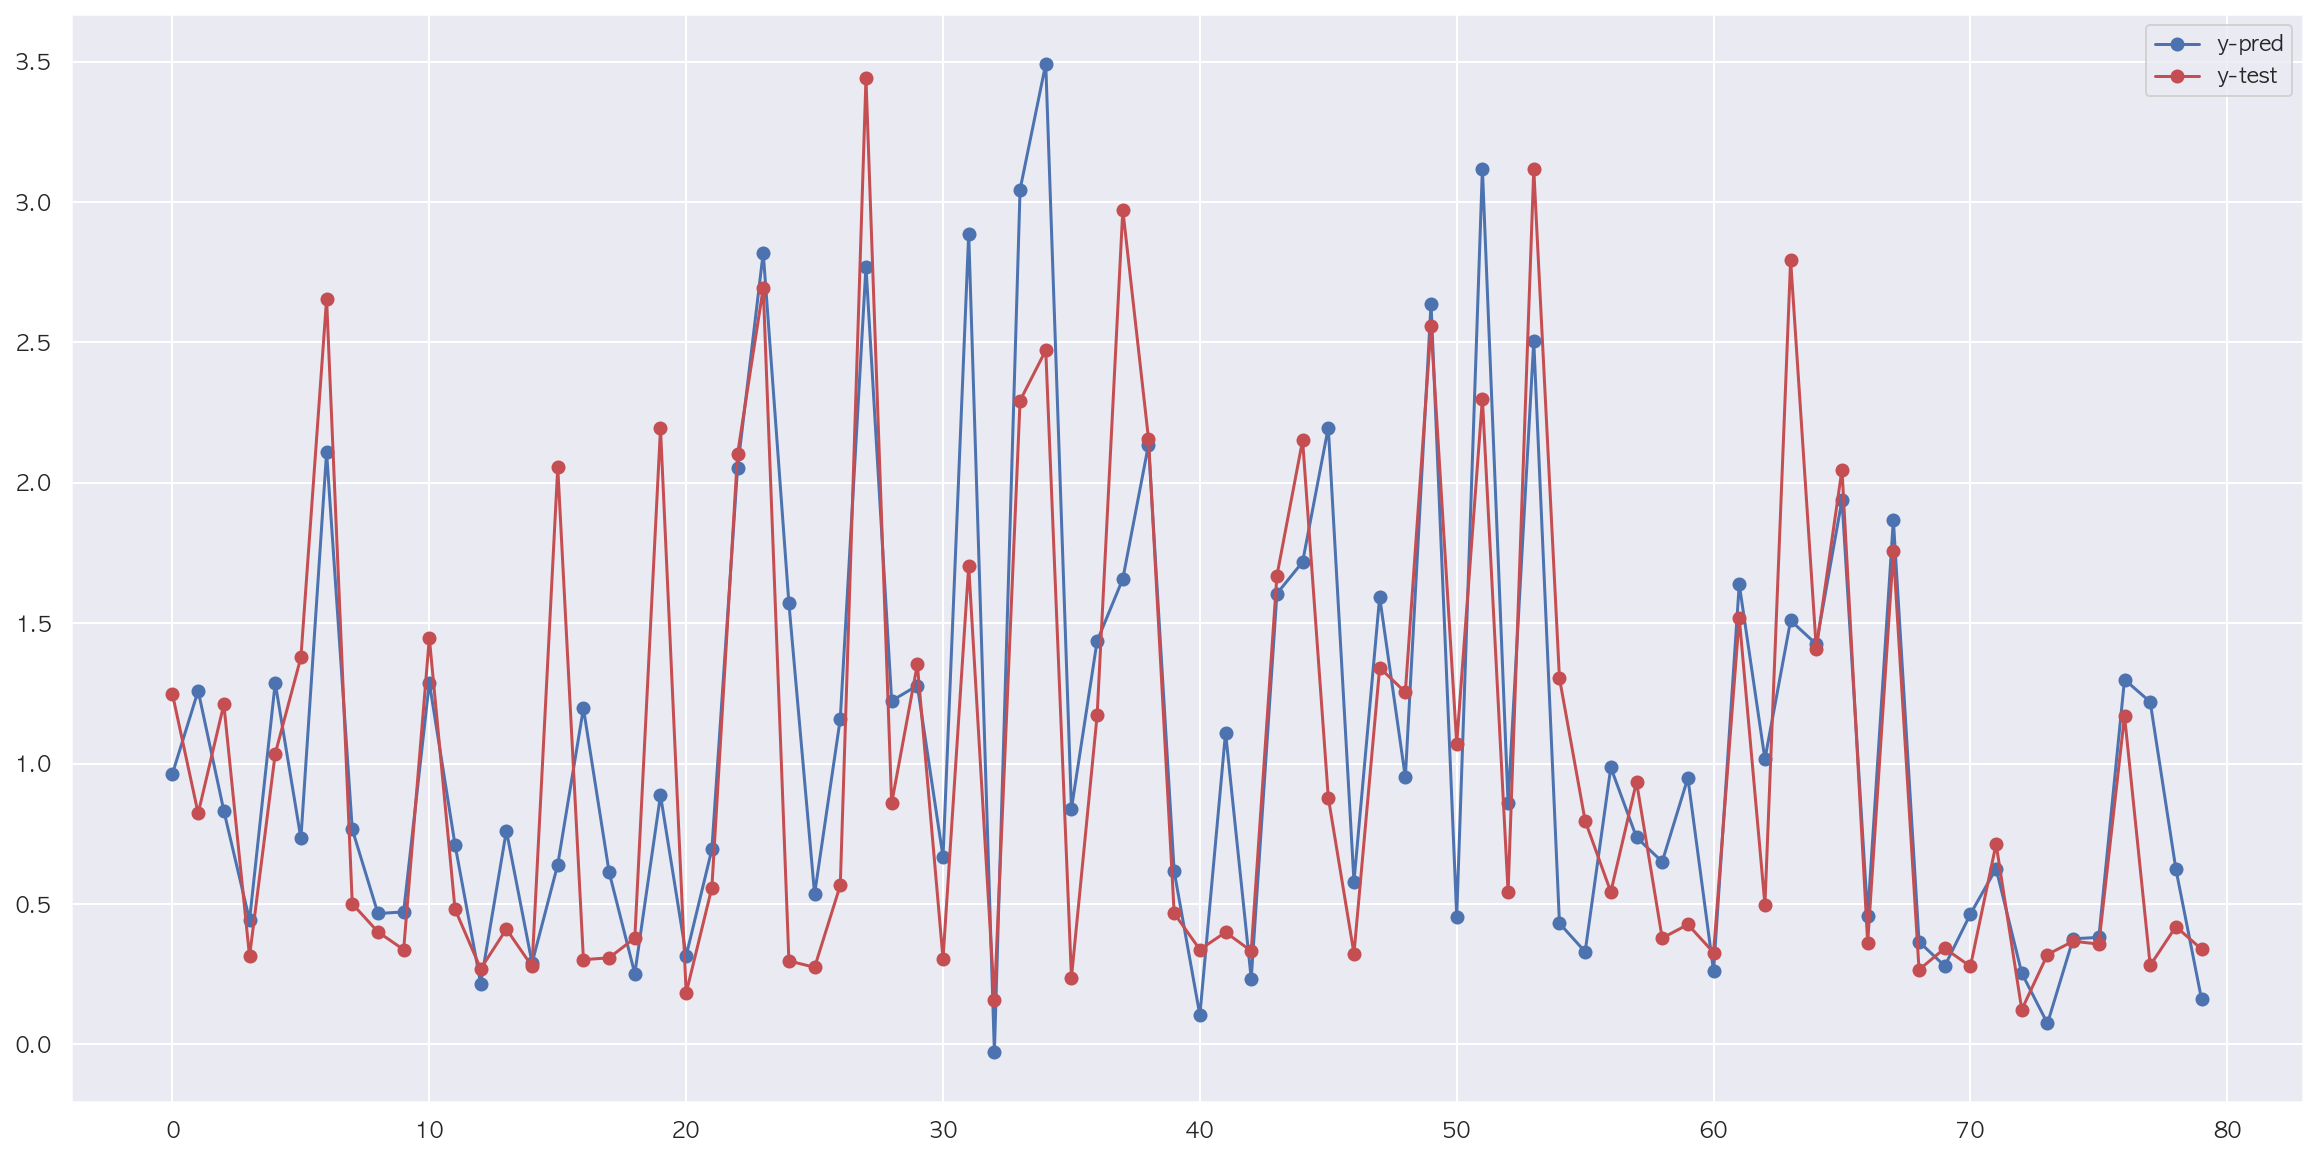

In [336]:
# window_size = 109
# n_window = df_power.shape[0]-window_size+1
# X, Y = [], []
# for w in range(n_window-1):
#     X.append(df_power[w:w+window_size])
#     Y.append(df_power[w+window_size, 0])
# X, Y = np.asarray(X), np.asarray(Y)

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, shuffle=False)

# X_train_f, X_test_f = [], []
# for r in range(X_train.shape[0]):
#     X_train_f.append(X_train[r].flatten())
# for r in range(X_test.shape[0]):
#     X_test_f.append(X_test[r].flatten())
# X_train_f, X_test_f = np.asarray(X_train_f), np.asarray(X_test_f)

model3 = LinearRegression(fit_intercept=False)
model3 = model3.fit(X_train_f, Y_train)
pred_y = model3.predict(X_test_f)

# pred_y = result2.predict(df_test)

plt.figure(figsize=(20,10))
plt.plot(pred_y[0:80], "bo-", label="y-pred")
plt.plot(Y_test[0:80], "ro-", label="y-test")
plt.legend()
plt.show()

## 7. PLS Regression

In [168]:
# PCA 차원축소는 독립변수들 간의 상관관계만 고려하지만 PLS 회귀분석은 독립변수와 종속변수 간의 상관관계까지 고려해 차원을 축소한다

In [1]:
df_power = pd.read_csv("household_power_consumption_H.csv", header=None, skiprows=1).values[:, 1:].astype("float")
print(df_power.shape)
print(df_power)

(34589, 8)
[[4.2228890e+00 2.2900000e-01 2.3464389e+02 ... 5.2777780e-01
  1.6861110e+01 5.2992590e+01]
 [3.6322000e+00 8.0033330e-02 2.3458017e+02 ... 6.7166667e+00
  1.6866667e+01 3.6953335e+01]
 [3.4002333e+00 8.5233330e-02 2.3323250e+02 ... 1.4333333e+00
  1.6683332e+01 3.8553890e+01]
 ...
 [1.6593333e+00 6.0033333e-02 2.3674100e+02 ... 6.6666670e-02
  0.0000000e+00 2.7588888e+01]
 [1.1637000e+00 6.1166666e-02 2.3939600e+02 ... 1.0666667e+00
  0.0000000e+00 1.8328333e+01]
 [9.3466670e-01 0.0000000e+00 2.3969000e+02 ... 0.0000000e+00
  0.0000000e+00 1.5577778e+01]]


In [2]:
df_norm = np.copy(df_power)
for c in range(8):
    df_norm[:, c] -= df_power[:, c].min()
    df_norm[:, c] /= (df_power[:, c].max()-df_power[:, c].min())
print(df_norm.shape)

(34589, 8)


In [3]:
from sklearn.model_selection import train_test_split

In [5]:
# 슬라이딩 윈도우 + flatten
window_size = 109
n_window = df_norm.shape[0]-window_size+1
X, Y = [], []

for w in range(n_window - 1):
    X.append(df_norm[w:w+window_size])
    Y.append(df_power[w+window_size, 0])
X, Y = np.asarray(X), np.asarray(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

X_train_f, X_test_f = [], []
for r in range(X_train.shape[0]):
    X_train_f.append(X_train[r].flatten())
for r in range(X_test.shape[0]):
    X_test_f.append(X_test[r].flatten())
X_train_f, X_test_f = np.asarray(X_train_f), np.asarray(X_test_f)

In [322]:
# components = 25
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
# PLS regression
pls = PLSRegression(n_components=25)
# Fit
pls.fit(X_train_f, Y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train_f, Y_train, cv=10)
# Calculate scores
score = r2_score(Y_train, y_cv)
mse = mean_squared_error(Y_train, y_cv)

In [323]:
score

0.6195083669218445

In [330]:
from sklearn.model_selection import cross_val_score

In [331]:
# components 1 ~ 20까지 r-squared값 측정
r2 = []
for i in tqdm(np.arange(1, 20)):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, X_train_f, Y_train, cv=10, scoring="r2").mean()
    r2.append(score)

(-1, 19.9)

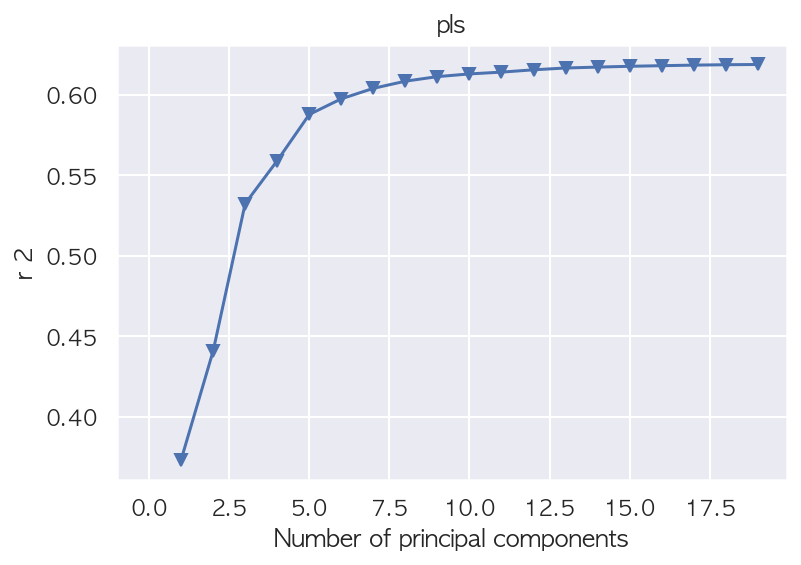

In [341]:
# components 1~20까지의 r-squared값 측정 그래프
plt.plot(np.arange(1, 20), np.array(r2), '-v')
plt.xlabel('Number of principal components')
plt.ylabel('r 2')
plt.title('pls')
plt.xlim(xmin=-1)

In [ ]:
# components = 8
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
# PLS regression
pls = PLSRegression(n_components=8)
# Fit
pls.fit(X_train_f, Y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train_f, Y_train, cv=10)
# Calculate scores
score = r2_score(Y_train, y_cv)
mse = mean_squared_error(Y_train, y_cv)

In [7]:
score

0.608896156668632

In [15]:
# components = 8
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
# PLS regression
pls = PLSRegression(n_components=8)
# Fit
pls.fit(X_test_f, Y_test)
# Cross-validation
y_cv = cross_val_predict(pls, X_test_f, Y_test, cv=10)
# Calculate scores
score = r2_score(Y_test, y_cv)
mse = mean_squared_error(Y_test, y_cv)

In [16]:
score

0.582319983956542

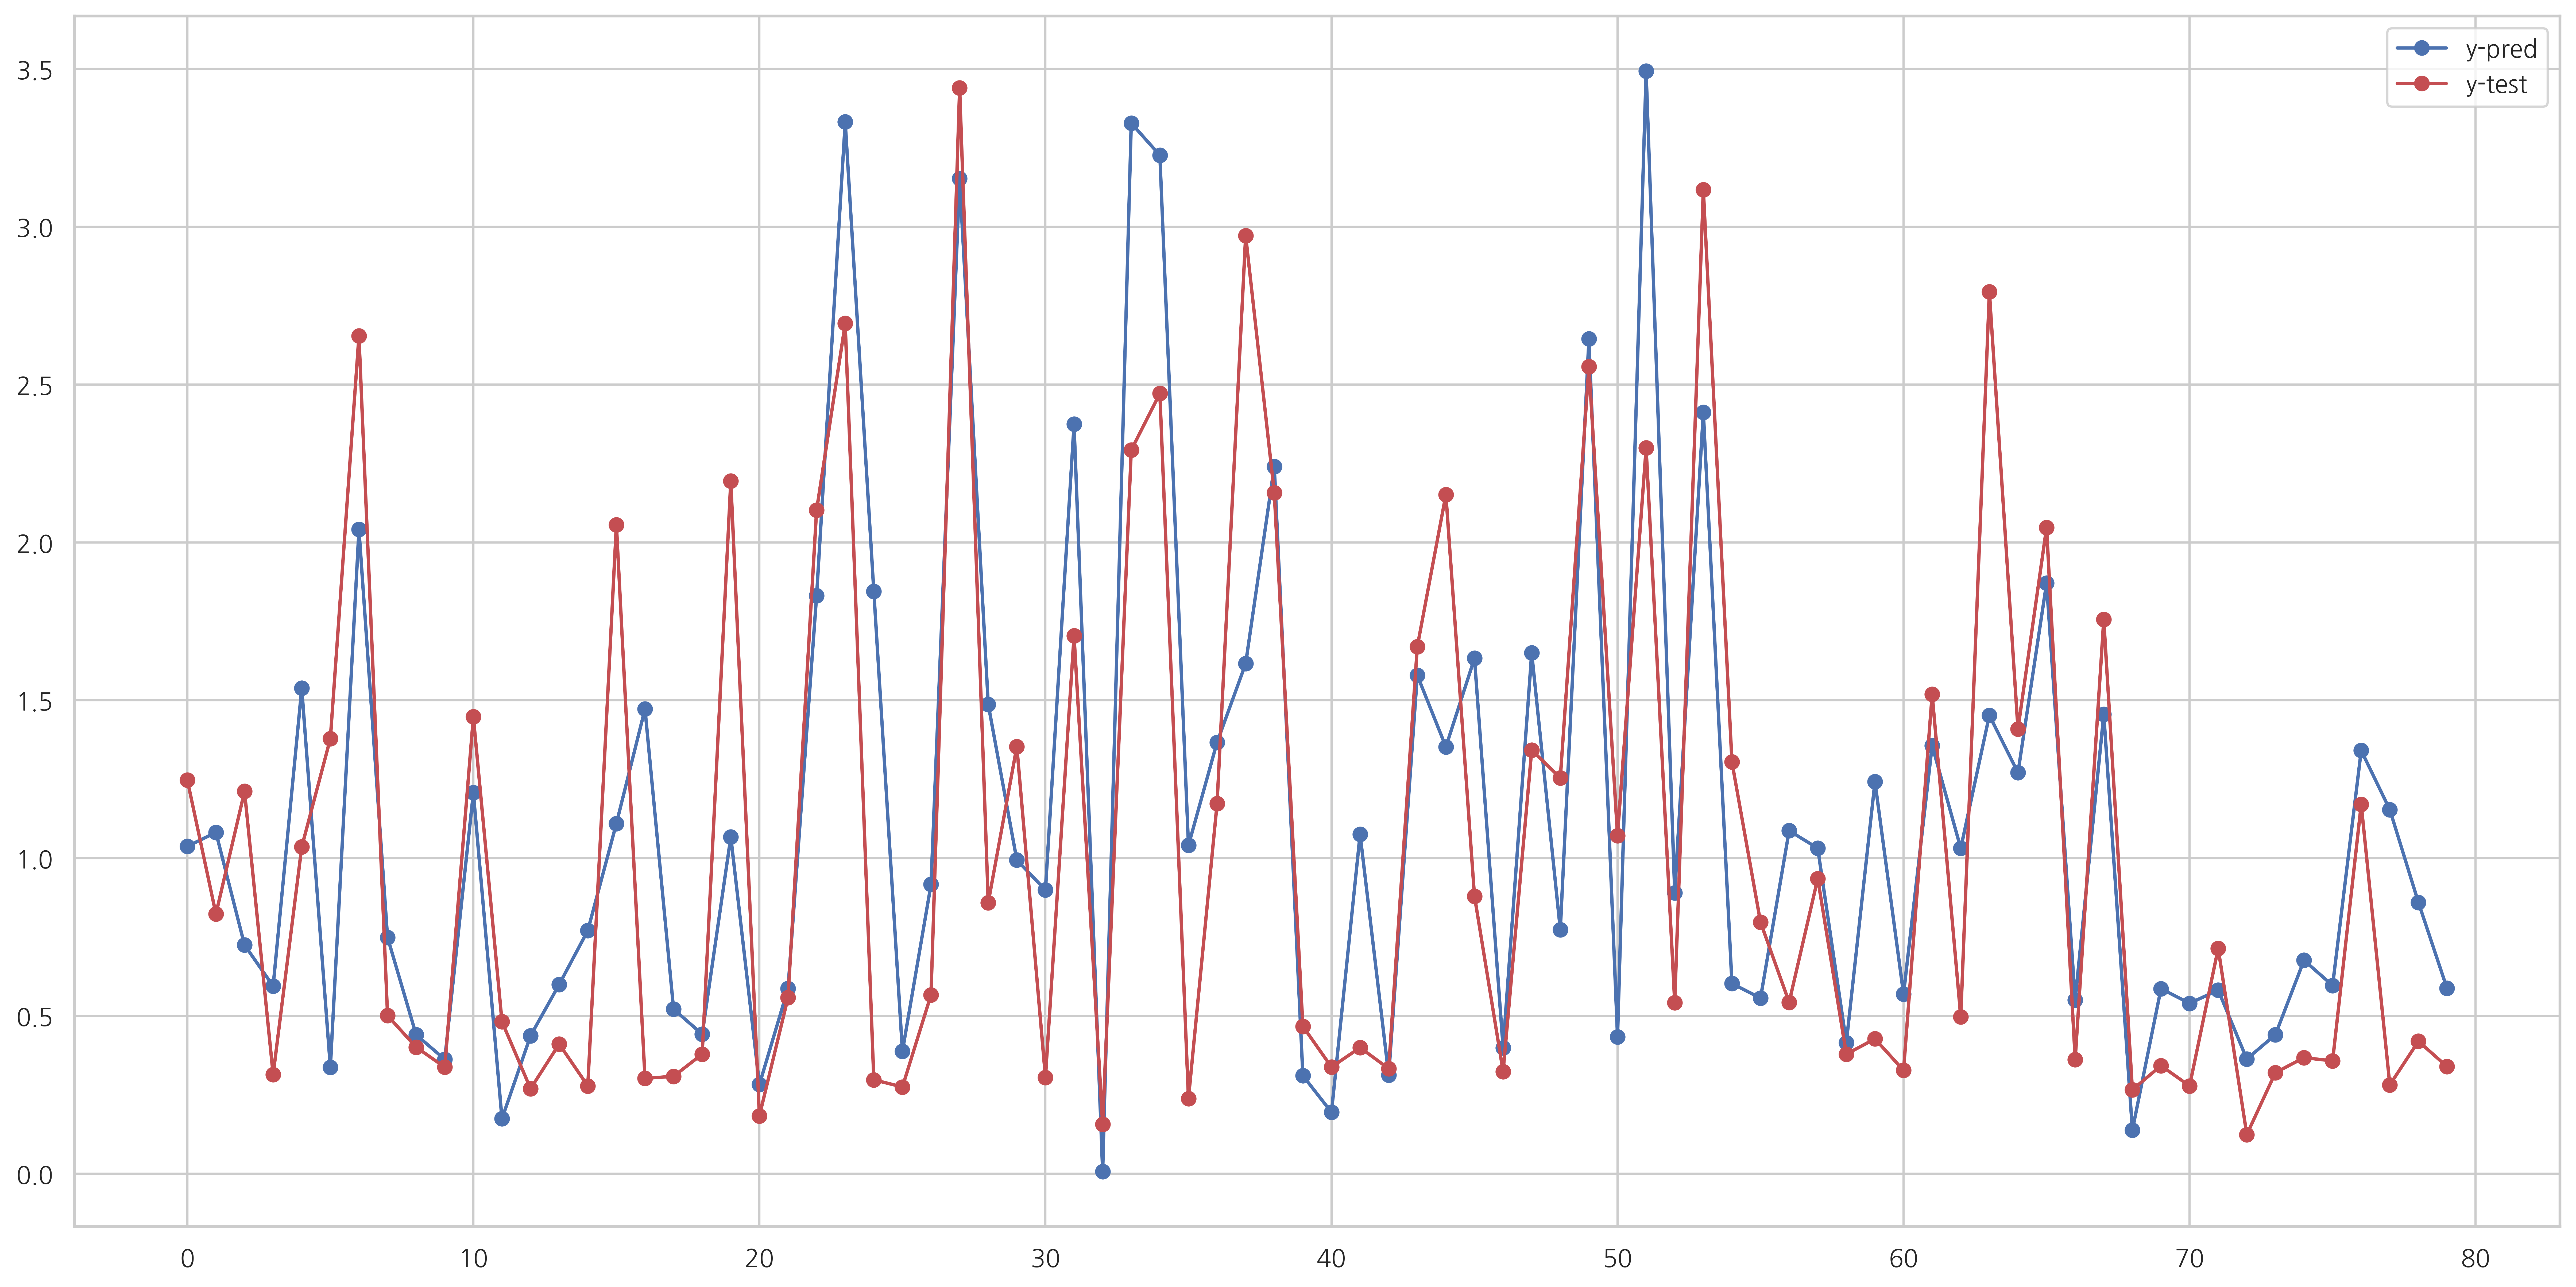

In [17]:
plt.figure(figsize=(20,10))
plt.plot(y_cv[0:80], "bo-", label="y-pred")
plt.plot(Y_test[0:80], "ro-", label="y-test")
plt.legend()
plt.show()

기여한 점
- sliding window 방식을 적용하여 OLS 시행
- 다중공선성을 낮추기 위해 PLS 시행

부족한 점
- 프랑스 가정의 전력사용 데이터이다 보니 데이터 자체의 정확성을 높이기 위한 자료수집에 한계
- 더욱 다양한 모델에 적용 필요 